# AIRBNB RENTAL PRICES ANALYSIS- Montreal Vs Toronto

<a id='intro'></a>
## Introduction

This project aims at evaluating data from Montreal and Toronto AirBnBs, that was retrieved from InsideAirBnB in November 2020. Inside AirBnB gathers and collects publicly available data about a city's AirBnB listings. Among the data provided is a detailed overview of property listings, calendar availability and AirBnB stay reviews.

I followed the CRISP-DM process for this project.


# Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#business">I- Business Understanding</a></li>
<li><a href="#unders">II- Data Understanding and Preparation</a></li>
<li><a href="#eda">III- Exploratory Data Analysis </a></li>  
<li><a href="#model">IV- Data Modeling and Evaluation </a></li>
<li><a href="#concl">Conclusion</a></li>
</ul>

<a id='business'></a>
## I- Business Understanding


I will handle the following questions: 
- How long have hosts been listing properties on Airbnb in both Montreal and Toronto?
- How many days a year do homeowners make their homes available to rent - Montreal Vs Toronto?
- How much do people charge to rent their homes? How does this compare from Montreal to Toronto?
- What is the ideal time to visit Montreal and Toronto ?
- Which Neighborhood is the most rated? 
- Which areas of Montreal and Toronto are the most expensive and which area is the best?
- What are the most common room types in Montreal and Toronto
- What are the most common words used to describe a listing? Are the same words used for Montreal and Toronto homes?
- What are the main factors that influence Airbnb renting price?
- How well can one predict the Airbnb renting price based on the data the two cities?


<a id='unders'></a>
## II- Data Understanding and Preparation

First, let's read in the necessary libraries and datasets.

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from pandas.plotting._matplotlib import converter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
from sklearn import datasets, metrics, model_selection, svm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
converter.register()
import itertools
import collections
import nltk
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

# Size of graphics
sns.set_style("white")
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 20
plt.rcParams["axes.grid"] = False
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

# Change pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# Load in the Montreal Data
calendar_m = pd.read_csv('calendar-m.csv')
reviews_m = pd.read_csv('reviews-m.csv')
listings_mo = pd.read_csv('listings-m.csv')

# Load in the Toronto Data
calendar_t = pd.read_csv('calendar-t.csv')
reviews_t = pd.read_csv('reviews-t.csv')
listings_to = pd.read_csv('listings-t.csv')

**`1.` Listings File**

In [3]:
# A concise summary of the dataframe,including the number of non-null values in each colum
listings_mo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13594 entries, 0 to 13593
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            13594 non-null  int64  
 1   listing_url                                   13594 non-null  object 
 2   scrape_id                                     13594 non-null  int64  
 3   last_scraped                                  13594 non-null  object 
 4   name                                          13586 non-null  object 
 5   description                                   13002 non-null  object 
 6   neighborhood_overview                         7875 non-null   object 
 7   picture_url                                   13594 non-null  object 
 8   host_id                                       13594 non-null  int64  
 9   host_url                                      13594 non-null 

In [4]:
# Number of rows and columns of dataset
print("Our Montreal dataset has", listings_mo.shape[0],"number of rows and", listings_mo.shape[1],"number of columns")

Our Montreal dataset has 13594 number of rows and 74 number of columns


_**Notes**_
- Listings dataset  have general information about the listing, lots of host-focused columns, neighborhood and spatial information, information on rooms and amenities, availability and review data, etc. 
- Again, many columns have no or only a low percentage of null-values. The columns "neighbourhood_group_cleansed", "bathrooms", "calendar_updated" and "license" are completely filled with null values. 
- "Price" seems to be a string instead of float.

In [5]:
# Number of rows and columns of dataset
print("Our Toronto dataset has", listings_to.shape[0],"number of rows and", listings_to.shape[1],"number of columns")

Our Toronto dataset has 18746 number of rows and 74 number of columns


In [6]:
# assessing room_types in Montreal
print("Montreal")
print(listings_mo.room_type.value_counts())

# assessing room_types in Toronto
print("Toronto")
print(listings_to.room_type.value_counts())

Montreal
Entire home/apt    9599
Private room       3820
Shared room         113
Hotel room           62
Name: room_type, dtype: int64
Toronto
Entire home/apt    11888
Private room        6462
Shared room          333
Hotel room            63
Name: room_type, dtype: int64


_**Notes**_

In both Montreal and Toronto, "Entire home/apt" is the most common room type. Other room types are "Private room", "Shared room", and "Hotel room".

**`2.`Reviews File**

In [7]:
# A concise summary of the dataframe,including the number of non-null values in each colum
reviews_m.info(), reviews_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291965 entries, 0 to 291964
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     291965 non-null  int64 
 1   id             291965 non-null  int64 
 2   date           291965 non-null  object
 3   reviewer_id    291965 non-null  int64 
 4   reviewer_name  291964 non-null  object
 5   comments       291765 non-null  object
dtypes: int64(3), object(3)
memory usage: 13.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499311 entries, 0 to 499310
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     499311 non-null  int64 
 1   id             499311 non-null  int64 
 2   date           499311 non-null  object
 3   reviewer_id    499311 non-null  int64 
 4   reviewer_name  499311 non-null  object
 5   comments       498920 non-null  object
dtypes: int64(3), object(

(None, None)

_**Notes**_

Reviews dataset lists individual reviews for the listings. Each row includes a listing id, review id, date, reviewer id, reviewer name, and the review text. 

**`3.` Calendar File**

In [8]:
calendar_m.head(), calendar_t.head()

(   listing_id        date available    price adjusted_price  minimum_nights  maximum_nights
 0      196007  2020-10-21         f  $130.00        $130.00             7.0           120.0
 1        2078  2020-10-22         f   $38.00         $38.00             2.0             7.0
 2        2078  2020-10-23         f   $38.00         $38.00             2.0             7.0
 3        2078  2020-10-24         f   $38.00         $38.00             2.0             7.0
 4        2078  2020-10-25         f   $38.00         $38.00             2.0             7.0,
    listing_id        date available    price adjusted_price  minimum_nights  maximum_nights
 0      775965  2020-10-11         f  $110.00        $110.00            14.0          1125.0
 1      382186  2020-10-10         f  $239.00        $239.00             1.0          1125.0
 2      382186  2020-10-11         t  $189.00        $189.00             1.0          1125.0
 3      382186  2020-10-12         t  $189.00        $189.00         

_**Notes**_

This dataset show the availability of listings on certain dates. Availability is encoded as f or t in the "available" column. 

The calendar provides information on the price  for staying at this AirBnB, and the number of minimum and maximum nights per stay.

To sum up:

In [9]:
print('The Montreal AirBnB data has {} listings, with properties rented out by {} hosts.'.
      format(listings_mo.shape[0], listings_mo.host_id.nunique()))
print('The Montreal AirBnB data has {} reviews, provided from {} to {}.'.
      format(reviews_m.shape[0], reviews_m.date.min(), reviews_m.date.max()))
print('The availability data for Montreal AirBnBs has been provided from {} to {} on {} homes.'.
      format(calendar_m.date.min(), calendar_m.date.max(), calendar_m.listing_id.nunique()))

The Montreal AirBnB data has 13594 listings, with properties rented out by 9073 hosts.
The Montreal AirBnB data has 291965 reviews, provided from 2010-06-20 to 2020-10-23.
The availability data for Montreal AirBnBs has been provided from 2020-10-19 to 2021-10-23 on 13594 homes.


In [10]:
print('The Toronto AirBnB data has {} listings, with properties rented out by {} hosts.'.
      format(listings_to.shape[0], listings_to.host_id.nunique()))
print('The Toronto AirBnB data has {} reviews, provided from {} to {}.'.
      format(reviews_t.shape[0], reviews_t.date.min(), reviews_t.date.max()))
print('The availability data for Toronto AirBnBs has been provided from {} to {} on {} homes.'.
      format(calendar_t.date.min(), calendar_t.date.max(), calendar_t.listing_id.nunique()))

The Toronto AirBnB data has 18746 listings, with properties rented out by 12477 hosts.
The Toronto AirBnB data has 499311 reviews, provided from 2009-08-20 to 2020-10-24.
The availability data for Toronto AirBnBs has been provided from 2020-10-09 to 2021-10-24 on 18746 homes.


##### Cleaning data
There are just some issues that needs to be fixed 

#### `Drop unnecessary columns or columns with high pourcentage of missing values` 

In [11]:
# Checking the percentage of missing values
listings_mo.isnull().mean() * 100

id                                                0.000000
listing_url                                       0.000000
scrape_id                                         0.000000
last_scraped                                      0.000000
name                                              0.058849
description                                       4.354862
neighborhood_overview                            42.070031
picture_url                                       0.000000
host_id                                           0.000000
host_url                                          0.000000
host_name                                         0.022069
host_since                                        0.022069
host_location                                     0.139768
host_about                                       45.417096
host_response_time                               44.115051
host_response_rate                               44.115051
host_acceptance_rate                             33.6030

In [12]:
# Dropping some features that doesn't look likely to contribute to the explanation of price

column_to_drop = ["id", "listing_url", "scrape_id", "name","description", "neighborhood_overview", 
                 "picture_url", "host_id", "host_url", "host_name", "host_about", "host_thumbnail_url",
                   "host_picture_url", "host_neighbourhood","host_listings_count", "host_total_listings_count", "host_verifications",'host_acceptance_rate', 
                    "neighbourhood", "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights",
                   "maximum_maximum_nights", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "calendar_updated", "has_availability", 
                   "availability_30", "availability_60", "availability_90", "availability_365", "calendar_last_scraped", "number_of_reviews_ltm", "last_review",
                    "license", "calculated_host_listings_count_entire_homes",  "calculated_host_listings_count_private_rooms",
                   "calculated_host_listings_count_shared_rooms",'bathrooms', 'neighbourhood_group_cleansed','host_has_profile_pic','host_identity_verified', 'bathrooms_text']

listings_m = listings_mo.drop(column_to_drop, axis=1)
listings_t = listings_to.drop(column_to_drop, axis=1)

_**Notes**_

I will Drop some variables that have a big pourcentage of missing values and  doesn't look likely to contribute to the explanation of my dependant variable which is price. 

#### ` Handling erroneous datatypes` : 

In [13]:
listings_m.dtypes

last_scraped                       object
host_since                         object
host_location                      object
host_response_time                 object
host_response_rate                 object
host_is_superhost                  object
neighbourhood_cleansed             object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                        int64
bedrooms                          float64
beds                              float64
amenities                          object
price                              object
minimum_nights                      int64
maximum_nights                      int64
number_of_reviews                   int64
number_of_reviews_l30d              int64
first_review                       object
review_scores_rating              float64
review_scores_accuracy            float64
review_scores_cleanliness         

##### Convert any column date from string to dateformat

In [14]:
#Converting to datetime
calendar_m['date']=pd.to_datetime(calendar_m['date'])
calendar_t['date']=pd.to_datetime(calendar_t['date'])

listings_m['host_since'] = pd.to_datetime(listings_m['host_since'])
listings_t['host_since'] = pd.to_datetime(listings_t['host_since'])

listings_m['first_review'] = pd.to_datetime(listings_m['first_review'])
listings_t['first_review'] = pd.to_datetime(listings_t['first_review'])


#### `Handling missing values` 

In the first part of cleaning section, i have dropped some columns that have high pourcentage of missing values.

In this part, i will be handling missing values to remove bias and improve predictions over time, by imputing the missing values, with median, mode...

In [15]:
# Checking the features with missing values
listings_m.isna().sum()[listings_m.isna().sum() > 0]

host_since                        3
host_location                    19
host_response_time             5997
host_response_rate             5997
host_is_superhost                 3
bedrooms                       1491
beds                            158
first_review                   3038
review_scores_rating           3344
review_scores_accuracy         3358
review_scores_cleanliness      3357
review_scores_checkin          3361
review_scores_communication    3356
review_scores_location         3364
review_scores_value            3364
reviews_per_month              3038
dtype: int64

##### Imputation of missing values with median

In [16]:
#convert host_response_rate into number and fill in missing values
listings_m['host_response_rate_'] = listings_m['host_response_rate'].str.replace('%','').astype(float)
listings_m = listings_m.drop(columns = ['host_response_rate'])

listings_t['host_response_rate_'] = listings_t['host_response_rate'].str.replace('%','').astype(float)
listings_t = listings_t.drop(columns = ['host_response_rate'])

#fill missing values with median
listings_m['host_response_rate_'] = listings_m['host_response_rate_'].fillna(listings_m['host_response_rate_'].median())
listings_t['host_response_rate_'] = listings_t['host_response_rate_'].fillna(listings_t['host_response_rate_'].median())

In [17]:
# fill missing values for review scores columns
review_scores_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                     'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                     'review_scores_value', 'reviews_per_month']

for col in review_scores_columns:
    listings_m[col].fillna(listings_m[col].median(), inplace=True)

for col in review_scores_columns:
    listings_t[col].fillna(listings_t[col].median(), inplace=True)

##### Fill in missing values with mode

I would Fill in missing values for  bedrooms and beds with mode as median/mean wont be a good filling criteria here.

In [18]:
#fill in missing values for  bedrooms and beds with mode as median/mean wont be a good filling criteria here
listings_m['bedrooms'] = listings_m['bedrooms'].fillna(listings_m['bedrooms'].mode()[0])
listings_m['beds'] = listings_m['beds'].fillna(listings_m['beds'].mode()[0])

listings_t['bedrooms'] = listings_t['bedrooms'].fillna(listings_t['bedrooms'].mode()[0])
listings_t['beds'] = listings_t['beds'].fillna(listings_t['beds'].mode()[0])

##### Fill in missing values of the remaining variables

In [19]:
#fill missing values for date columns 
date_columns=['host_since','first_review']

for col in date_columns:
    listings_m[col].fillna(listings_m["last_scraped"].value_counts().index[0], inplace=True)

for col in date_columns:
    listings_t[col].fillna(listings_t["last_scraped"].value_counts().index[0], inplace=True)

In [20]:
# Fill the remaining columns for Montreal
listings_m["host_location"] = listings_m["host_location"].fillna(listings_m["host_location"].value_counts().index[0])
listings_m["host_response_time"] = listings_m["host_response_time"].fillna("a few days or more")
listings_m["host_is_superhost"] = listings_m["host_is_superhost"].fillna("f")

In [21]:
# Fille the remaining columns for Toronto
listings_t["host_location"] = listings_t["host_location"].fillna(listings_t["host_location"].value_counts().index[0])
listings_t["host_response_time"] = listings_t["host_response_time"].fillna("a few days or more")
listings_t["host_is_superhost"] = listings_t["host_is_superhost"].fillna("f")

#### `Handling categorical variables` 

In [22]:
#dummy variables for 'amenities'
listings_m.amenities[0].replace('"','').replace("'",'').replace('{','').replace('}','').replace('[','').replace(']','').split(',')

['Hair dryer',
 ' Dryer',
 ' Lock on bedroom door',
 ' First aid kit',
 ' Wifi',
 ' Heating',
 ' Hot water',
 ' Host greets you',
 ' Shampoo',
 ' Smoke alarm',
 ' Free street parking',
 ' Essentials',
 ' Iron',
 ' Kitchen']

In [23]:
#Create function that fill in dummy columns

def get_value_from_list(row, column_name, value):
    
    ''' 
    Fill in dummy column for values 
    
    '''
   
    val = 0.0
    try:
        vals = row[column_name].replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val


# Create function that Split values in columns
def split_list_to_columns(df, column_name, max_dummies_num = 10):
    
    ''' 
    
    Split values in columns, which contain lists (for example column name: amenities ) 
    
    '''
       
    # get dictionary of unique values in lists across dataset rows
    val_dict = {}

    for unique_value in df[column_name].unique(): 
        for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
            if value in val_dict:
                val_dict[value] = val_dict[value] + 1
            else:
                val_dict[value] = 0
                
    values_sorted = sorted(val_dict.items(), key=lambda kv: kv[1], reverse = True)
      
    # split into columns
    for value in values_sorted[: max_dummies_num]:
        df[column_name + '_' + value[0]] = df.apply(lambda row: get_value_from_list(row, column_name, value[0]),axis=1)
        
    return

In [24]:
# apply function for Montreal data
split_list_to_columns(listings_m, 'amenities')

listings_m = listings_m.drop(columns = ['amenities'])

In [25]:
#apply function for Toronto Data
split_list_to_columns(listings_t, 'amenities')

listings_t = listings_t.drop(columns = ['amenities'])

#### `Additional cleaning` 

In [26]:
# Replacing columns with f/t with 0/1
listings_m.replace({'f': 0, 't': 1}, inplace=True)
listings_t.replace({'f': 0, 't': 1}, inplace=True)

In [27]:
# Change the available to a boolean
calendar_m.available.replace('f', False, inplace=True)
calendar_m.available.replace('t', True, inplace=True)

calendar_t.available.replace('f', False, inplace=True)
calendar_t.available.replace('t', True, inplace=True)

In [28]:
#creating new columns and drop unused- Montreal
listings_m["listing_duration"] = (pd.to_datetime(listings_m["last_scraped"]) - pd.to_datetime(listings_m["first_review"])).astype('str').str.split(expand = True).iloc[:,0].astype('int')
listings_m["host_duration"] = (pd.to_datetime(listings_m["last_scraped"]) - pd.to_datetime(listings_m["host_since"])).astype('str').str.split(expand = True).iloc[:,0].astype('int')
listings_m["calculated_reviews_per_month"] = (listings_m["number_of_reviews"] / ((listings_m["last_scraped"].apply(pd.to_datetime) - listings_m["host_since"].apply(pd.to_datetime)) / np.timedelta64(1, 'M')).replace({0.0:1.0})).round(1)
listings_m['review_score'] = ((listings_m["review_scores_accuracy"] + listings_m["review_scores_cleanliness"] + listings_m["review_scores_checkin"] + listings_m["review_scores_communication"] + listings_m["review_scores_location"] + listings_m["review_scores_value"])/6).round(2)


cols_to_drop = ["last_scraped", "first_review", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_value", "reviews_per_month"]

listings_m = listings_m.drop(labels=cols_to_drop, axis=1)

In [29]:
#creating new columns and drop unused- Toronto
listings_t["listing_duration"] = (pd.to_datetime(listings_t["last_scraped"]) - pd.to_datetime(listings_t["first_review"])).astype('str').str.split(expand = True).iloc[:,0].astype('int')
listings_t["host_duration"] = (pd.to_datetime(listings_t["last_scraped"]) - pd.to_datetime(listings_t["host_since"])).astype('str').str.split(expand = True).iloc[:,0].astype('int')
listings_t["calculated_reviews_per_month"] = (listings_t["number_of_reviews"] / ((listings_t["last_scraped"].apply(pd.to_datetime) - listings_t["host_since"].apply(pd.to_datetime)) / np.timedelta64(1, 'M')).replace({0.0:1.0})).round(1)
listings_t['review_score'] = ((listings_t["review_scores_accuracy"] + listings_t["review_scores_cleanliness"] + listings_t["review_scores_checkin"] + listings_t["review_scores_communication"] + listings_t["review_scores_location"] + listings_t["review_scores_value"])/6).round(2)


cols_to_drop = ["last_scraped", "first_review", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_value", "reviews_per_month"]

listings_t = listings_t.drop(labels=cols_to_drop, axis=1)

In [30]:
#Converting to datetime
calendar_m['date']=pd.to_datetime(calendar_m['date'])
calendar_t['date']=pd.to_datetime(calendar_t['date'])
listings_mo['host_since'] = pd.to_datetime(listings_mo['host_since'])
listings_to['host_since'] = pd.to_datetime(listings_to['host_since'])
listings_m['host_since'] = pd.to_datetime(listings_m['host_since'])
listings_t['host_since'] = pd.to_datetime(listings_t['host_since'])

In [31]:
# Clean pricing-replacing any dollar signs and commas found with space
calendar_m['price_clean'] = calendar_m['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))
calendar_t['price_clean'] = calendar_t['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))

listings_m['price_clean'] = listings_m['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))
listings_t['price_clean'] = listings_t['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))

listings_m=listings_m.drop(columns=['price'])
listings_t=listings_t.drop(columns=['price'])

<a id='eda'></a>
## III- Exploratory Data Analysis

**`1.`How long have hosts been listing properties on Airbnb in both Montreal and Toronto?**

In Montreal,the first Airbnb host joined on 11 August 2008,and the most recent joined on 20 October 2020.
In Toronto, the first Airbnb host joined on 08 August 2008,and the most recent joined on 25 October 2020.


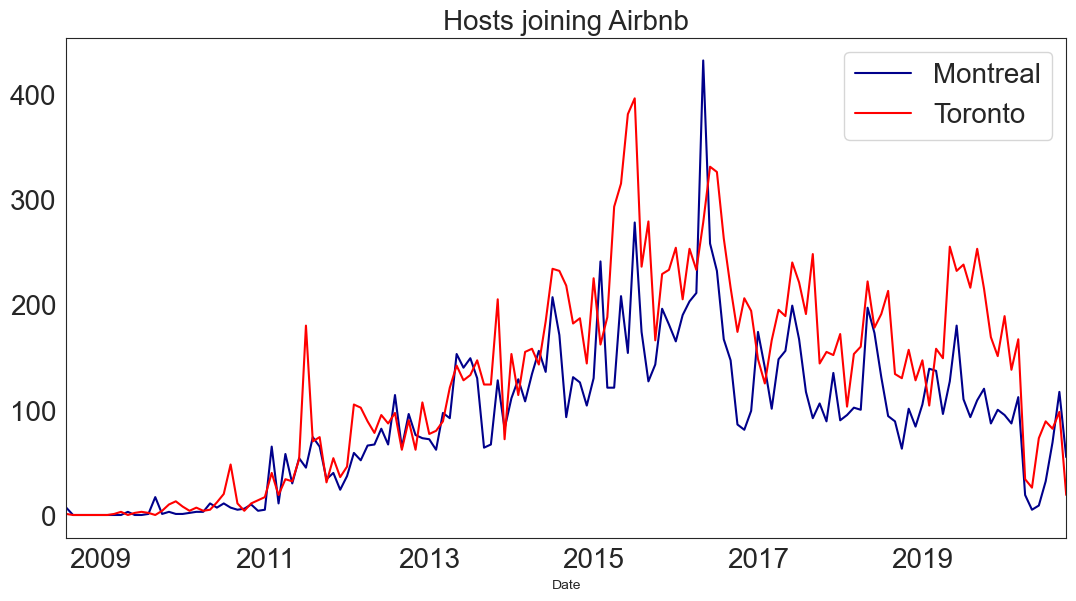

In [32]:
sns.set_style("white")
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
listings_m.set_index('host_since').resample('MS').size().plot(label='Montreal', color='darkblue')
listings_t.set_index('host_since').resample('MS').size().plot(label='Toronto', color='red')
ax.legend(loc='best', fontsize=20)
plt.xlabel('Date')
plt.title('Hosts joining Airbnb', fontsize=20);
print(f"In Montreal,the first Airbnb host joined on {min(listings_mo.host_since).strftime('%d %B %Y')},and the most recent joined on {max(listings_m.host_since).strftime('%d %B %Y')}.")
print(f"In Toronto, the first Airbnb host joined on {min(listings_to.host_since).strftime('%d %B %Y')},and the most recent joined on {max(listings_t.host_since).strftime('%d %B %Y')}.")

_**Notes**_

The oldest Montreal and toronto listing  was first listed on the site in August 2008. From 2011 onwards, the number of listings started increasing considerably. However, growth in the number of new hosts (of those currently listing on the site) has been decreasing since the second half of the year 2016.The significant decrease was observed in 2020 due to the covid 19 pandemic.

**`2.` How many days a year do homeowners make their homes available to rent - Montreal Vs Toronto?**

In [33]:
# calculate proportion available to rent
prop_available_m=calendar_m.groupby('listing_id').mean()['available'].reset_index()
prop_available_m.columns=['listing_id', 'prop_day_available']

prop_available_t=calendar_t.groupby('listing_id').mean()['available'].reset_index()
prop_available_t.columns=['listing_id', 'prop_day_available']

In [34]:
# Descriptive statistics 
print(prop_available_t.prop_day_available.describe()), print(prop_available_m.prop_day_available.describe())

count    18746.000000
mean         0.345644
std          0.375097
min          0.000000
25%          0.000000
50%          0.227397
75%          0.690411
max          1.000000
Name: prop_day_available, dtype: float64
count    13594.000000
mean         0.375778
std          0.389098
min          0.000000
25%          0.000000
50%          0.241096
75%          0.800000
max          1.000000
Name: prop_day_available, dtype: float64


(None, None)

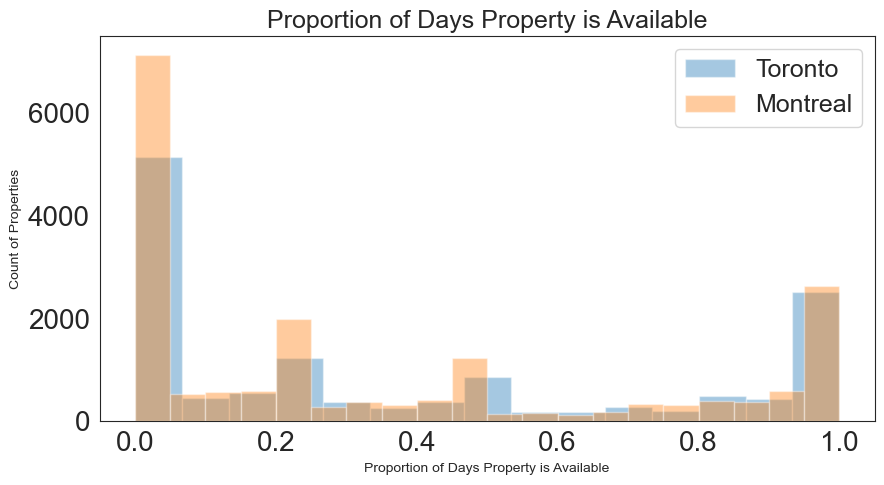

In [35]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10, 5))
for a in [prop_available_m.prop_day_available, prop_available_t.prop_day_available]:
    sns.distplot(a, ax=ax,kde=False)   
    
plt.xlabel('Proportion of Days Property is Available');
plt.ylabel('Count of Properties');
plt.title('Proportion of Days Property is Available', fontsize=18);
ax.legend(labels=['Toronto','Montreal'], fontsize=18);

_**Notes**_

The way people use their homes for rentals in Montreal and Toronto is pretty similar, where a majority of people hardly ever rent out their homes at all.

**`3.` How much do people charge to rent their homes? How does this compare from Montreal to Toronto?**

In [36]:
# creating copies of the calendars
price_m = calendar_m.copy()
price_t = calendar_t.copy()

#  calculating average price grouped by date
avg_price_date_m = price_m.groupby('date')['price_clean'].mean().reset_index()
avg_price_date_m['date'] = pd.to_datetime(avg_price_date_m['date'])

avg_price_date_t = price_t.groupby('date')['price_clean'].mean().reset_index()
avg_price_date_t['date'] = pd.to_datetime(avg_price_date_t['date'])

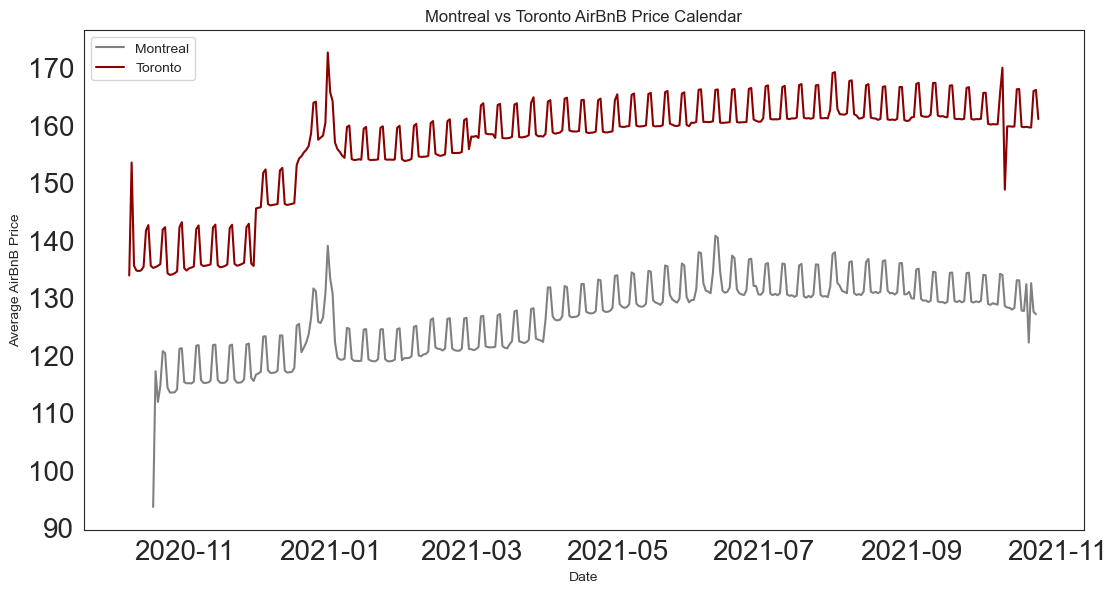

In [37]:
sns.set_style("white")
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.plot(avg_price_date_m['date'], avg_price_date_m['price_clean'], 'gray', label='Montreal')
ax.plot(avg_price_date_t['date'], avg_price_date_t['price_clean'], 'darkred', label='Toronto')
ax.legend(loc='best')
ax.set_xlabel('Date')
ax.set_ylabel('Average AirBnB Price')
plt.title('Montreal vs Toronto AirBnB Price Calendar');


_**Notes**_

On average prices in Toronto are just more expensive than in Montreal all year round. 

In both cities, prices spike on weekends. The price curves are relatively flat, except the price increase during Christmas season. In Toronto, prices spike more than 40 dollars on average from the beginning to end of December, in Montreal around 30 dollars. Another exception is the upward tendency during the spring and summer months. 

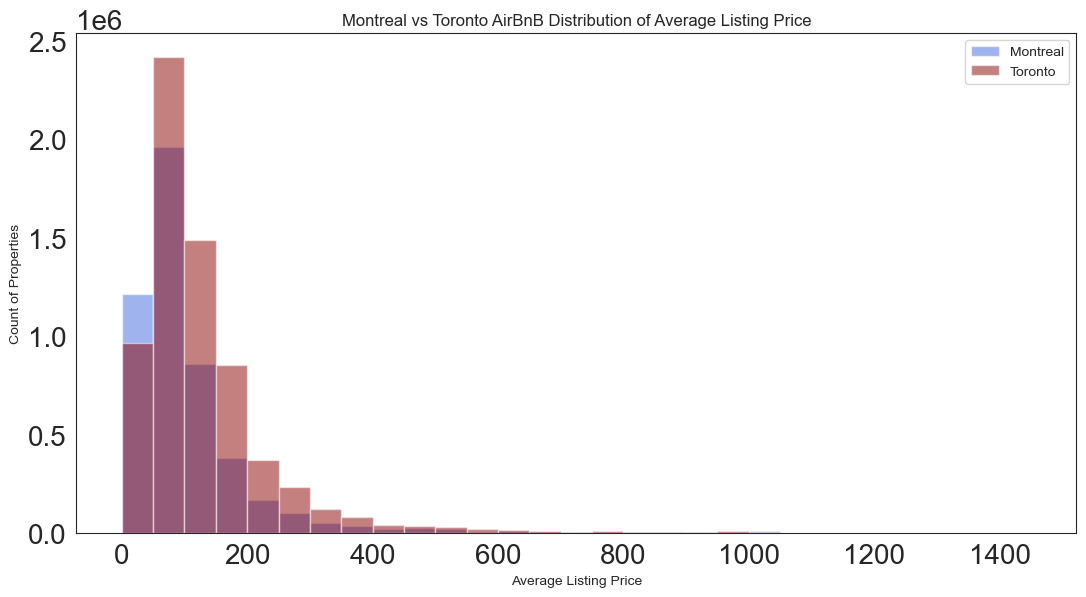

In [38]:
#Plot distribution of prices
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.hist(calendar_m['price_clean'][calendar_m['price_clean'] < 1500],alpha=0.5,bins=np.arange(0,1500,50),label='Montreal',  color='royalblue')
ax.hist(calendar_t['price_clean'][calendar_t['price_clean'] < 1500],alpha=0.5,bins=np.arange(0,1500,50),label='Toronto',  color='darkred')
ax.legend()
ax.set_xlabel('Average Listing Price')
ax.set_ylabel('Count of Properties')
plt.title('Montreal vs Toronto AirBnB Distribution of Average Listing Price');

_**Notes**_

From the above, , you can see that the distribution of the average listing prices appears to be pretty similar between Montreal and Toronto homes. However, the Toronto homes are more expensive on average (higher maximum and average mean and median prices).

In [39]:
print('Out of the available listings, the median AirBnB price in Montreal is ${}.'.
      format(int(calendar_m['price_clean'].median())),
      'Assuming the median price, a 6-night stay in a Montreal AirBnB costs ${}.'.
      format((int(calendar_m['price_clean'].median())*6)), 
      'The cheapest AirBnB home in Montreal is listed at ${}.'.
      format((int(calendar_m['price_clean'].min()))),
      'A 6-night stay would need a ${} budget.'.
      format((int(calendar_m['price_clean'].min())*6)),
      'The most expensive AirBnB home in Montreal is listed at ${}.'.
      format((int(calendar_m['price_clean'].max()))),
      'A 6-night stay would need a ${} budget.'.
      format((int(calendar_m['price_clean'].max())*6)))

Out of the available listings, the median AirBnB price in Montreal is $80. Assuming the median price, a 6-night stay in a Montreal AirBnB costs $480. The cheapest AirBnB home in Montreal is listed at $13. A 6-night stay would need a $78 budget. The most expensive AirBnB home in Montreal is listed at $13294. A 6-night stay would need a $79764 budget.


In [40]:
print('Out of the available listings, the median AirBnB price in Toronto is ${}.'.
      format(int(calendar_t['price_clean'].median())),
      'Assuming the median price, a 6-night stay in a Toronto AirBnB costs ${}.'.
      format((int(calendar_t['price_clean'].median())*6)), 
      'The cheapest AirBnB home in Toronto is listed at ${}.'.
      format((int(calendar_t['price_clean'].min()))),
      'A 6-night stay would need a ${} budget.'.
      format((int(calendar_t['price_clean'].min())*6)),
      'The most expensive AirBnB home in Toronto is listed at ${}.'.
      format((int(calendar_t['price_clean'].max()))),
      'A 6-night stay would need a ${} budget.'.
      format((int(calendar_t['price_clean'].max())*6)))

Out of the available listings, the median AirBnB price in Toronto is $100. Assuming the median price, a 6-night stay in a Toronto AirBnB costs $600. The cheapest AirBnB home in Toronto is listed at $10. A 6-night stay would need a $60 budget. The most expensive AirBnB home in Toronto is listed at $13137. A 6-night stay would need a $78822 budget.


**`4.`What is the ideal time to visit Montreal and Toronto ?**

In [41]:
prop_avail_perday_m=calendar_m.groupby('date').mean()['available'].reset_index()
prop_avail_perday_t=calendar_t.groupby('date').mean()['available'].reset_index()

prop_avail_perday_t['date'] = pd.to_datetime(prop_avail_perday_t['date'])
prop_avail_perday_m['date'] = pd.to_datetime(prop_avail_perday_m['date'])

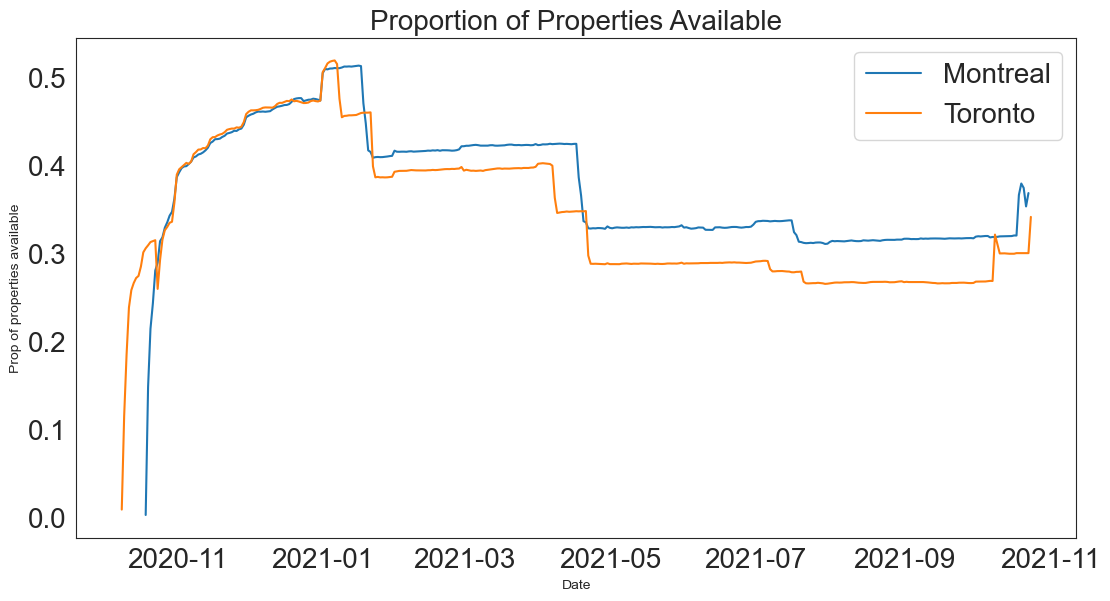

In [42]:
sns.set_style("white")
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.plot(prop_avail_perday_m.date, prop_avail_perday_m.available, label='Montreal')
ax.plot(prop_avail_perday_t.date, prop_avail_perday_t.available, label='Toronto')
ax.legend(loc='best', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Prop of properties available')
plt.title('Proportion of Properties Available', fontsize=20);

_**Notes**_

In both Montreal and Toronto, the proportion of available listings for any given date never rises above 50%. The calendar data was retrieved in November 2020, so it is no surprise, that the curve starts close to fully not available. Until December, the curves rise to almost 50% in both Toronto and Montreal.
In January 2021, the availability decreases again in the form of stairs. The first huge decrease is at the beginning of January but remain almost flat until spring before another jump to over 70% occurs in both cities.

Of course, that holiday season (Christmas time) and the summer are the best time to visit both cities. Nevertheless, if you are searching for lower prices and more choices of AirBnBs, autumn and winter (except December) are the ideal time to visit these beautiful cities.


**`5.`Which Neighborhood is the most rated? Popularity of airbnb by location**

In [43]:
top_5_toronto = listings_t['neighbourhood_cleansed'].value_counts()[:5].sort_values(ascending=False)
top_5_montreal = listings_m['neighbourhood_cleansed'].value_counts()[:5].sort_values(ascending=False)

top_5_toronto = pd.DataFrame({'neighbourhood_cleansed':top_5_toronto.index}).merge(listings_t, how='left')
top_5_montreal = pd.DataFrame({'neighbourhood_cleansed':top_5_montreal.index}).merge(listings_m, how='left')

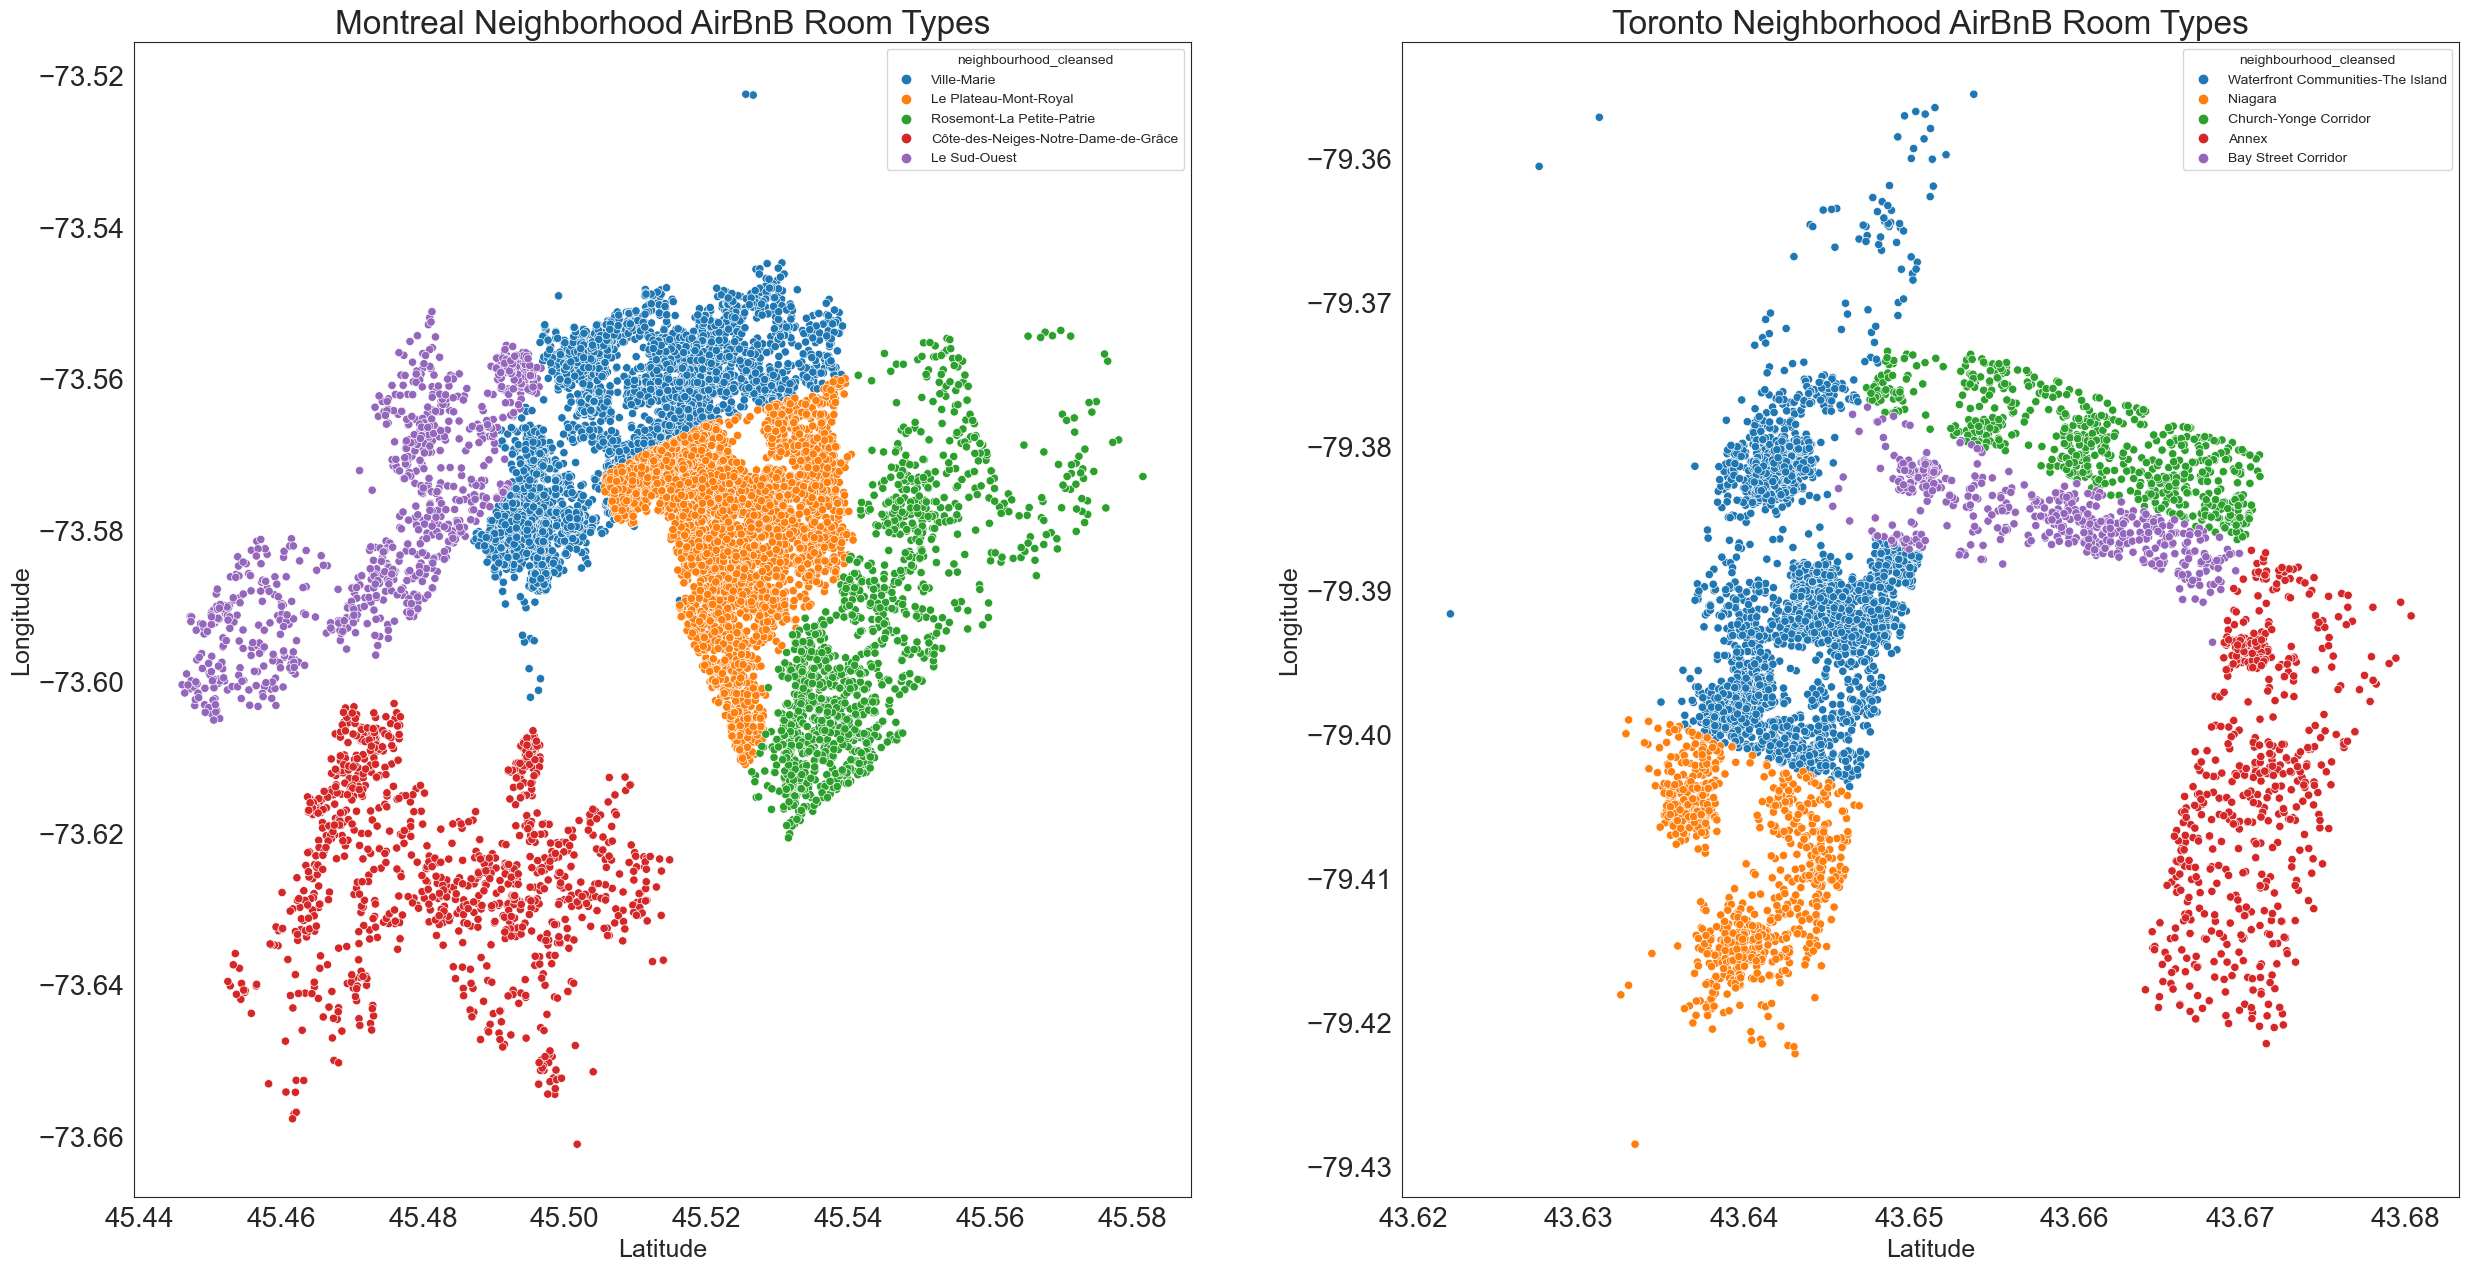

In [44]:
# plotting listings by room type 
fig = plt.figure(figsize=(30,15))

plt.subplot(1, 2, 1)
sns.scatterplot(data=top_5_montreal,x='latitude',y='longitude',hue='neighbourhood_cleansed')
plt.ylabel('Longitude',fontsize=18)
plt.xlabel('Latitude', fontsize=18)
ax.legend(loc='best', fontsize=50)
plt.title('Montreal Neighborhood AirBnB Room Types', fontsize=24)

plt.subplot(1, 2, 2)
sns.scatterplot(data=top_5_toronto,x='latitude',y='longitude',hue='neighbourhood_cleansed')
plt.ylabel('Longitude',fontsize=18)
plt.xlabel('Latitude',fontsize=18)
ax.legend(loc='best', fontsize=50)
plt.title('Toronto Neighborhood AirBnB Room Types', fontsize=24);

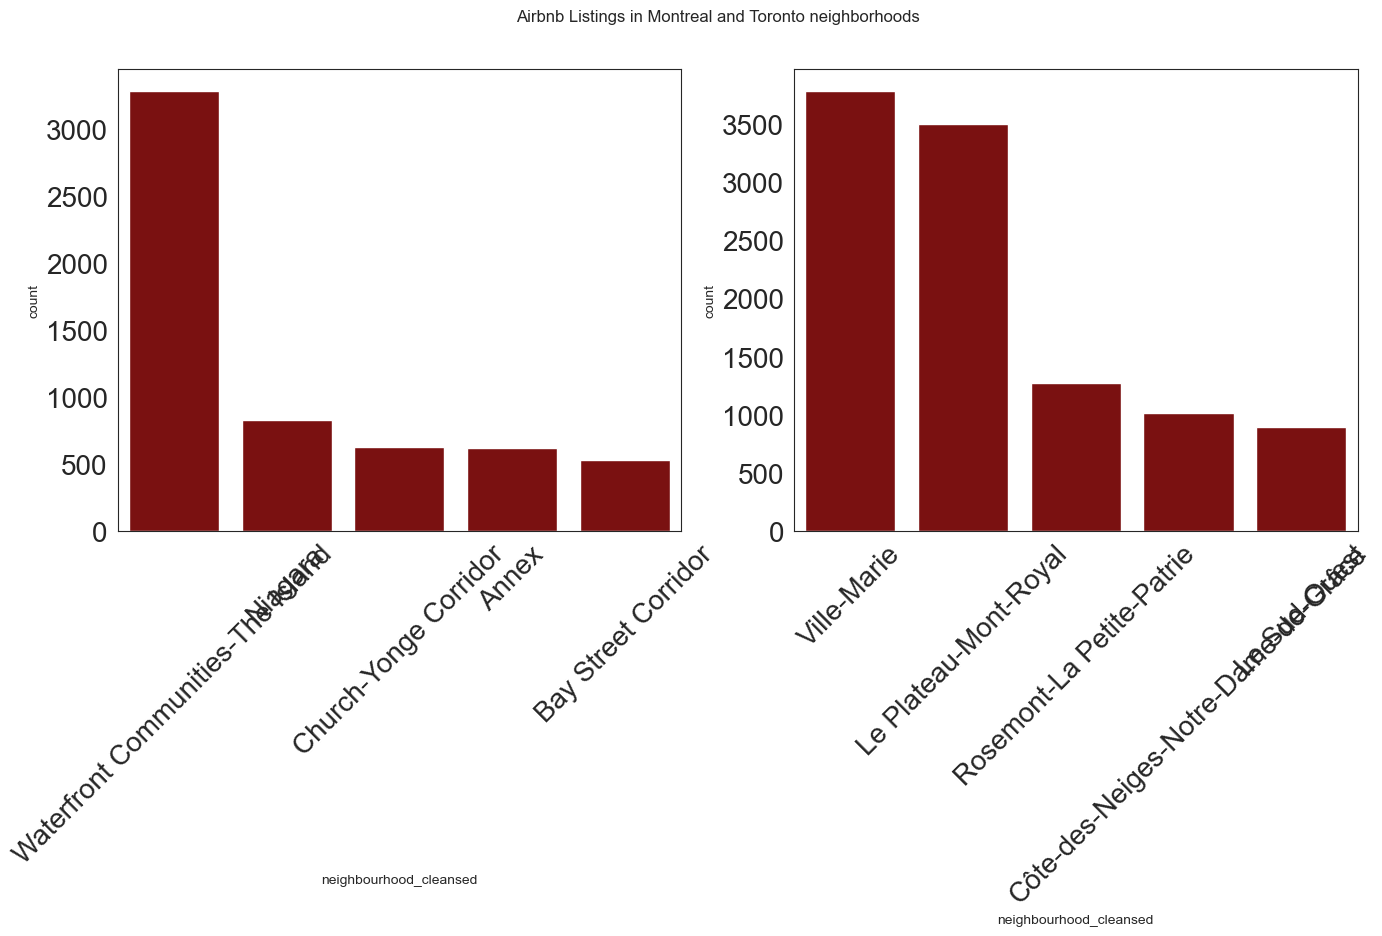

In [45]:
fig = plt.figure(figsize=(16,6))
fig.suptitle('Airbnb Listings in Montreal and Toronto neighborhoods')
plt.subplot(1,2,1)
sns.countplot(data=top_5_toronto, x='neighbourhood_cleansed', color='darkred')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
sns.countplot(data=top_5_montreal, x='neighbourhood_cleansed', color='darkred');
plt.xticks(rotation=45);

_**Notes**_

In Toronto, "Waterfront Communities-The Island" is the neighborhood that has by far the highest number of Airbnb listings. In Montreal, the highest AirBnB density is in Ville-Marie, followed by Le Plateau Mont Royal. Staten Island has the least amount of Airbnbs. 

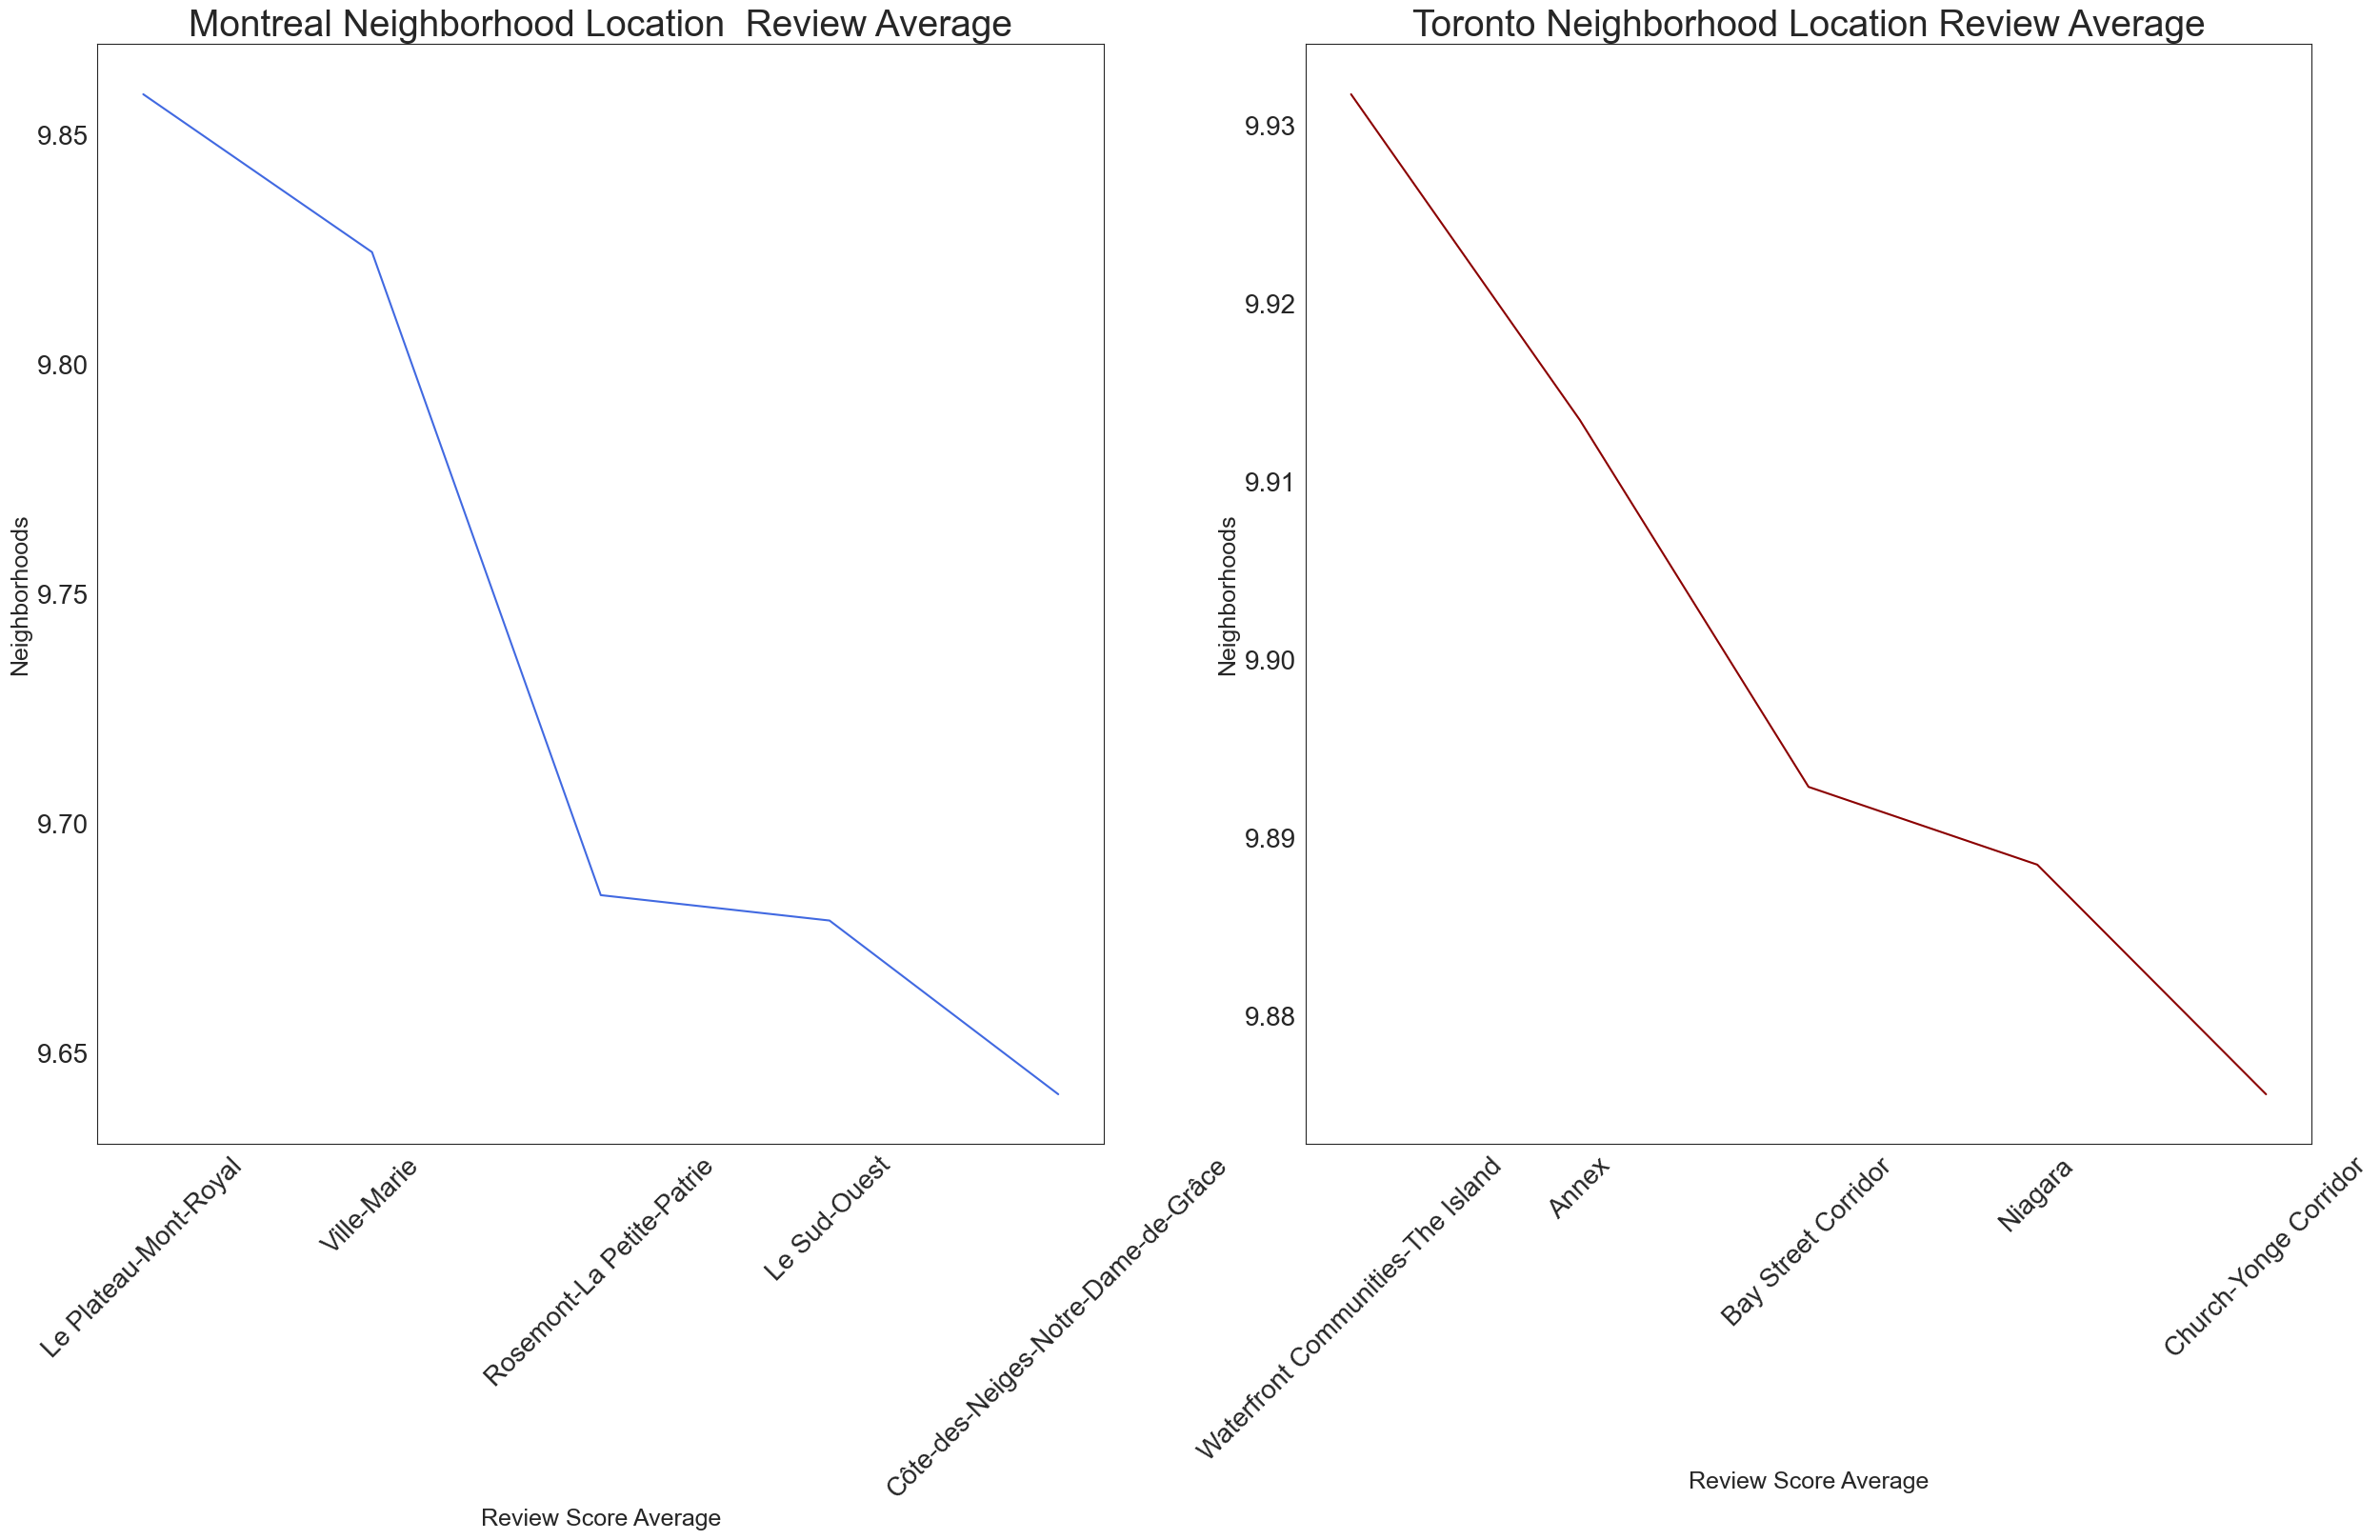

In [46]:
# calculating average review score by neighborhood
top_reviews_m = top_5_montreal.groupby('neighbourhood_cleansed').review_scores_location.mean().sort_values(ascending=False)
top_reviews_t = top_5_toronto.groupby('neighbourhood_cleansed').review_scores_location.mean().sort_values(ascending=False)

#plotting the scores by neighborhood
fig = plt.figure(figsize=(30,15))

plt.subplot(1, 2,1)
plt.plot(top_reviews_m, label='Montreal', color='royalblue')
plt.ylabel('Neighborhoods', fontsize=18)
plt.xlabel('Review Score Average', fontsize=18)
plt.xticks(rotation=45)
plt.title('Montreal Neighborhood Location  Review Average', fontsize=28)

plt.subplot(1, 2,2)
plt.plot(top_reviews_t, label='Toronto', color='darkred')
plt.ylabel('Neighborhoods', fontsize=18)
plt.xlabel('Review Score Average', fontsize=18)
plt.xticks(rotation=45)
plt.title('Toronto Neighborhood Location Review Average', fontsize=28);

_**Notes**_

Waterfront, Annex, Niagara, Bay Street Corridorand Church yonge have the higher average location scores than the highest rated Montreal neighborhood (Le plateau Mont Royal).
In Toronto, "Waterfront Communities-The Island" receives the highest score because it closes to the most famous city hotspots (CN Tower, Toronto International Film Festival, Toronto Island Park and beaches on the park…) and has the more convenient transportation (subway streetcars, ferries). While in Montreal, “Le plateau Mont-Royal » receives the highest score, it’s the most densely populated borough in Canada.


**`6.`Which areas of Montreal and Toronto are the most expensive and which area is the best?**

In [47]:
top_prices_t = top_5_toronto.groupby('neighbourhood_cleansed').price_clean.mean().sort_values(ascending=False)
top_prices_m = top_5_montreal.groupby('neighbourhood_cleansed').price_clean.mean().sort_values(ascending=False)

m_snapshot = top_5_montreal.query('price_clean < 500')
t_snapshot = top_5_toronto.query('price_clean < 500')

In [48]:
display(top_prices_t, top_prices_m)

neighbourhood_cleansed
Waterfront Communities-The Island    194.374808
Annex                                184.012340
Bay Street Corridor                  159.581372
Niagara                              159.472110
Church-Yonge Corridor                131.287384
Name: price_clean, dtype: float64

neighbourhood_cleansed
Ville-Marie                            134.178491
Le Sud-Ouest                           122.939019
Le Plateau-Mont-Royal                  117.605127
Rosemont-La Petite-Patrie              102.563673
Côte-des-Neiges-Notre-Dame-de-Grâce     98.358938
Name: price_clean, dtype: float64

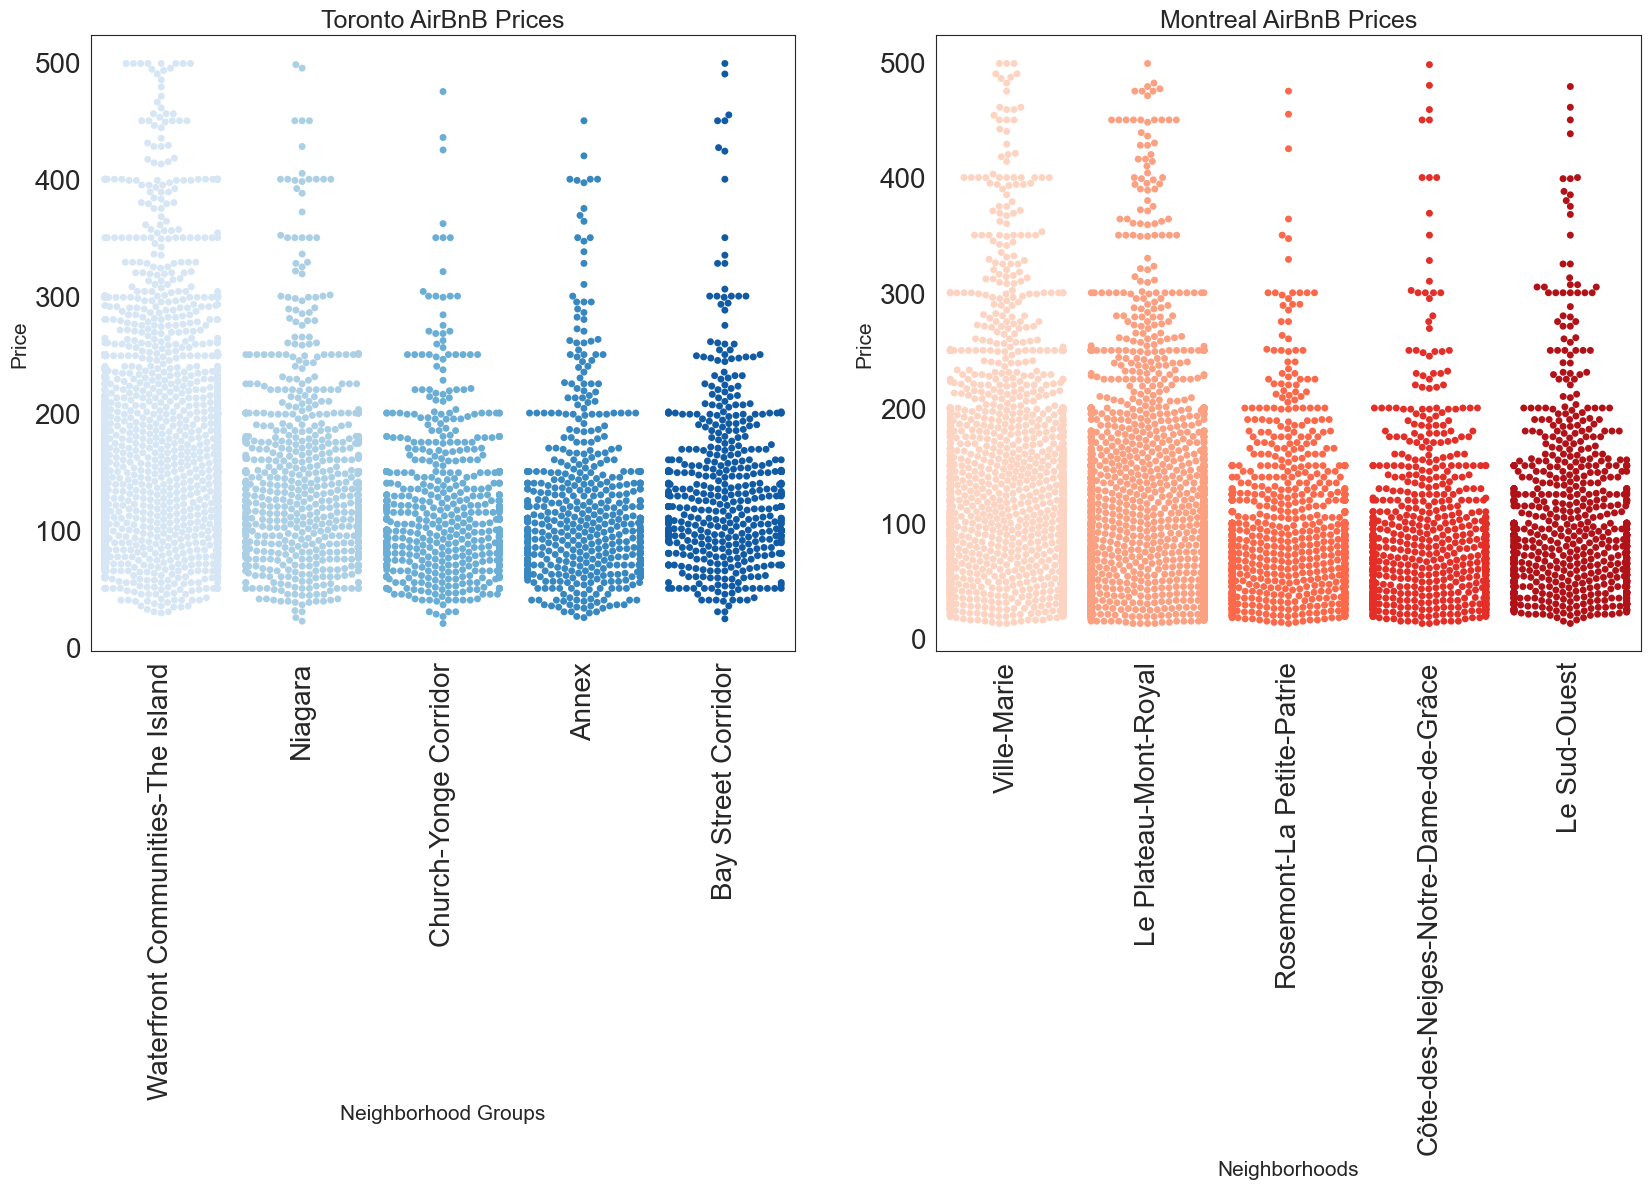

In [49]:
# plotting sawrm plots for price by neighbourhood

plt.figure(figsize=(20,8))
plt.subplot(1, 2,1)
sns.swarmplot(data=t_snapshot, x='neighbourhood_cleansed', y='price_clean', palette='Blues')
plt.ylabel('Price', fontsize=15)
plt.xlabel('Neighborhood Groups', fontsize=15)
plt.xticks(rotation=90)
plt.title('Toronto AirBnB Prices', fontsize=18)

plt.subplot(1, 2,2)
sns.swarmplot(data=m_snapshot, x='neighbourhood_cleansed', y='price_clean', palette='Reds')
plt.ylabel('Price', fontsize=15)
plt.xlabel('Neighborhoods',fontsize=15)
plt.xticks(rotation=90)
plt.title('Montreal AirBnB Prices', fontsize=18);
fig.show();

_**Notes**_

It is obvious that the highly rated locations would also tend to be costly this is because in the case of constant supply, the higher the demand, the higher the price is.

In Toronto, the 5 evaluated neighborhoods (top 5 with the highest number of Airbnb listings) are on the more expensive side, especially in the “Waterfront communities” averaging at 194.37 dollars. For low budget travelers, there are some chances to find low-priced listings in “Annex” and “Church-Yonge Corridor”.

In Montreal, “Ville marie” and “Le plateau Mont royal” have the most balanced distribution of lower price and medium to high price listings. On average, “ville marie” seems like relatively the priciest of all (the top 5 analysed), averaging at 134 dollars. For low budget travelers, there are chances to find low-priced listings in “Rosemont La Petite Patrie”, “Cote des neiges notre Dame de Grace” and “le Sud Ouest”.



**`7`Most common room types in Montreal and Toronto**

Now that we have an idea of the availability, prices of homes and best neighbors, I would look at other characteristics of listings.

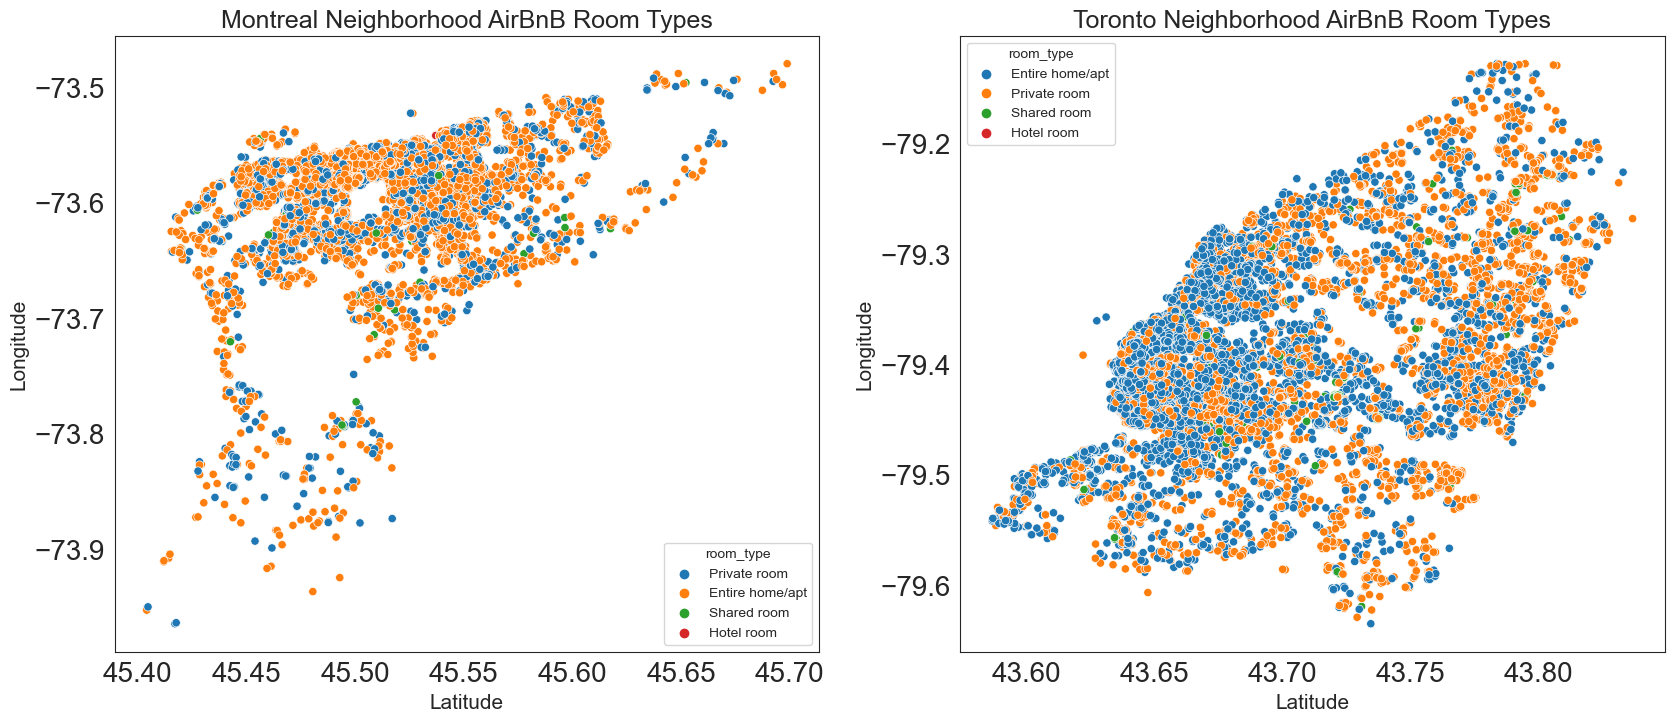

In [50]:
# plotting listings by room type 
fig = plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
sns.scatterplot(data=listings_m,x='latitude',y='longitude',hue='room_type')
plt.ylabel('Longitude', fontsize=15)
plt.xlabel('Latitude', fontsize=15)
plt.title('Montreal Neighborhood AirBnB Room Types', fontsize=18)

plt.subplot(1, 2, 2)
sns.scatterplot(data=listings_t,x='latitude',y='longitude',hue='room_type')
plt.ylabel('Longitude', fontsize=15)
plt.xlabel('Latitude', fontsize=15)
plt.title('Toronto Neighborhood AirBnB Room Types', fontsize=18);

In [51]:
for col in ['room_type']:
    print('**In Montreal**')
    print(listings_m[col].value_counts(normalize=True))
    print('**In Toronto**')
    print(listings_t[col].value_counts(normalize=True))

**In Montreal**
Entire home/apt    0.706120
Private room       0.281006
Shared room        0.008312
Hotel room         0.004561
Name: room_type, dtype: float64
**In Toronto**
Entire home/apt    0.634162
Private room       0.344714
Shared room        0.017764
Hotel room         0.003361
Name: room_type, dtype: float64


_**Notes**_

Almost listings, in both Montreal and Toronto are entire homes (renting the entire property). Most of the remaining ones are private rooms (renting a bedroom and possibly also a bathroom, but there will be other people in the property). Fewer than 2% are shared rooms (sharing a room with either the property owner or other guests).


**`8.` What are the most common words used to describe a listing? Are the same words used for Montreal and Toronto homes?**

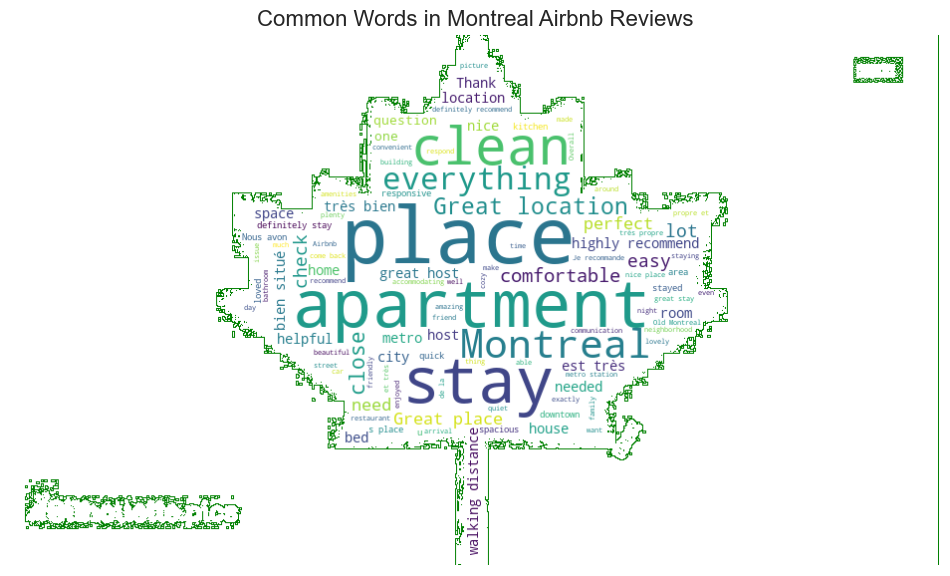

In [52]:
# Wordcloud for dog_breed visualization:
text_m =reviews_m.loc[:, 'comments'].str.cat(others=None, sep=' ')

# Read the mask image
montreal_mask = np.array(Image.open('maple.jpg'))

# Instantiate word cloud object
wc = WordCloud(background_color='white', max_words=100, mask=montreal_mask, stopwords=STOPWORDS,
              width=640, height=480,contour_width=.01, 
                      contour_color='green')
# Generate word cloud
wc.generate(text_m)
# Show word cloud
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Common Words in Montreal Airbnb Reviews', fontsize=16)
plt.axis('off');

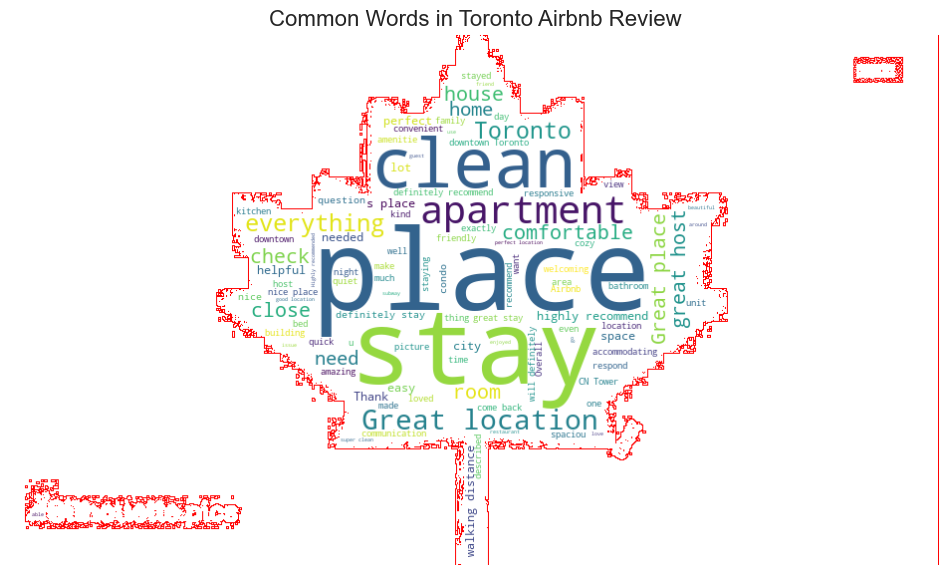

In [53]:
# Wordcloud for dog_breed visualization:
text_t =reviews_t.loc[:, 'comments'].str.cat(others=None, sep=' ')

# Read the mask image
montreal_mask = np.array(Image.open('maple.jpg'))

# Instantiate word cloud object
wc = WordCloud(background_color='white', max_words=100, mask=montreal_mask, stopwords=STOPWORDS,
              width=640, height=480,contour_width=.01, 
                      contour_color='red')
# Generate word cloud
wc.generate(text_t)
# Show word cloud
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Common Words in Toronto Airbnb Review', fontsize=16)
plt.axis('off');

I tried to find  words that describe a stay that were used across both Montreal and Toronto.  Overall it seems that both locations sound like great places to stay at an AirBnB. 

Montreal "apartment"s are "clean" "place"s to "stay". Guests appreciate "everything", "confortable room"s, "great location"s and "host"s. They also mention the "subway".

Toronto "apartment"s are "clean" "place"s to "stay". Here, "great location", "great place and the "helpful amd great host" are mentioned in this sequence. Again, they would " highly recommend" the "apartment", where "everything" has been "comfortable".


<a id='model'></a>
## IV- Data modelling and Evaluation

### The case of Montreal

In [54]:
# Create a new dataframe for regression
num_features = listings_m.dtypes[listings_m.dtypes != 'object'].index.tolist()
data_for_r = pd.DataFrame(listings_m[num_features])
# Log Transform the dependant variable
data_for_r["price_clean"] = np.log(data_for_r [["price_clean"]])

In [55]:
#  Creates a heatmap of correlations between features 

def collinearity_heatmap(df, figsize=(11,9)):
    
    """
    
    Creates a heatmap of correlations between features in the dataframe.
    
      
    """
        
    # Set the style of the visualization
    sns.set(style="white")

    corr = data_for_r.corr()

    # Generate a mask the size of our matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the  figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

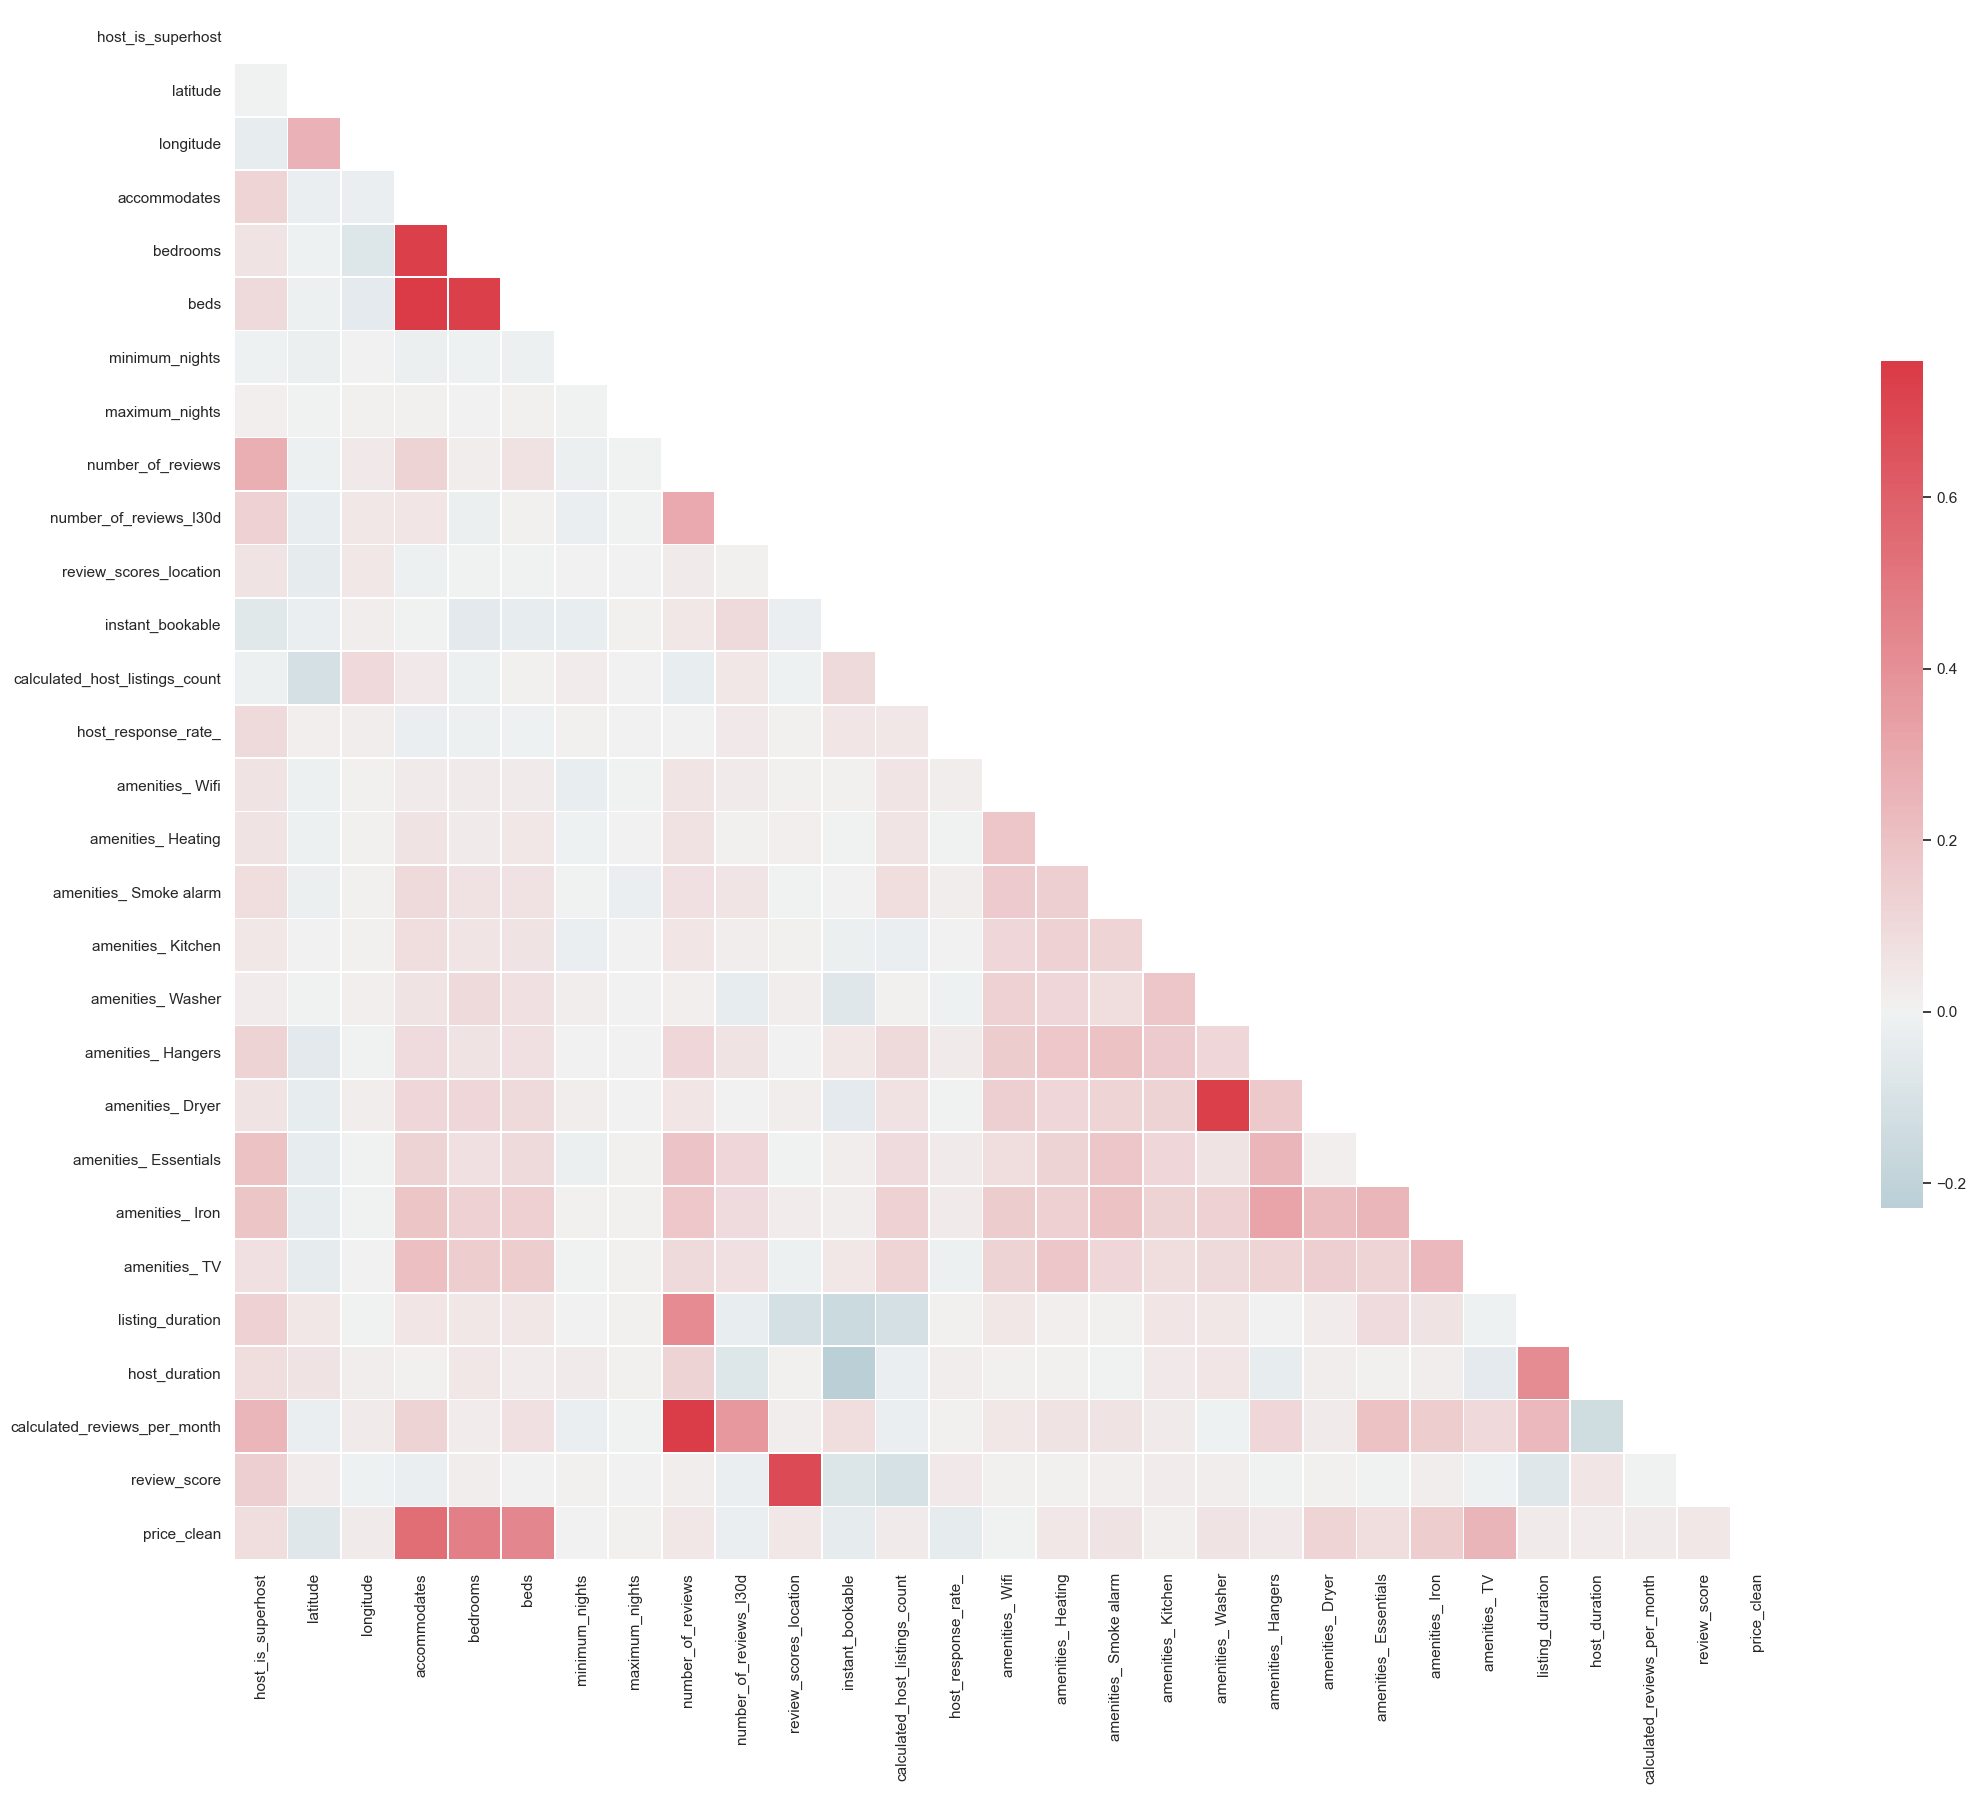

In [56]:
collinearity_heatmap(data_for_r, figsize=(25,22))

_**Notes**_

There are some colinearity between certain variables, as an example, beds, bedrooms and accomodates.
All collinear variables would be dropped in the next step.

In [57]:
# Dropping from the X some colinear variables
X_r=data_for_r .drop(["price_clean",'host_since','bedrooms','beds','review_scores_location','number_of_reviews'], axis=1)
y_r = data_for_r [["price_clean"]]

# Scaling
scaler = StandardScaler()
X_r = pd.DataFrame(scaler.fit_transform(X_r), columns=list(X_r.columns))
y_r=scaler.fit_transform(y_r)

In [58]:
# Create train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, test_size=0.2, random_state=42)
print('X_train.shape: ', X_train.shape, '\tX_test.shape: ', X_test.shape, '\nY_train.shape: ', y_train.shape, '\tY_test.shape: ', y_test.shape)

X_train.shape:  (10875, 24) 	X_test.shape:  (2719, 24) 
Y_train.shape:  (10875, 1) 	Y_test.shape:  (2719, 1)


##### Linear regression

R2: 0.33919178771804337
MAE: 0.6039169474440905
MSE: 0.6324986070965117
RMSE: 0.795297810317941


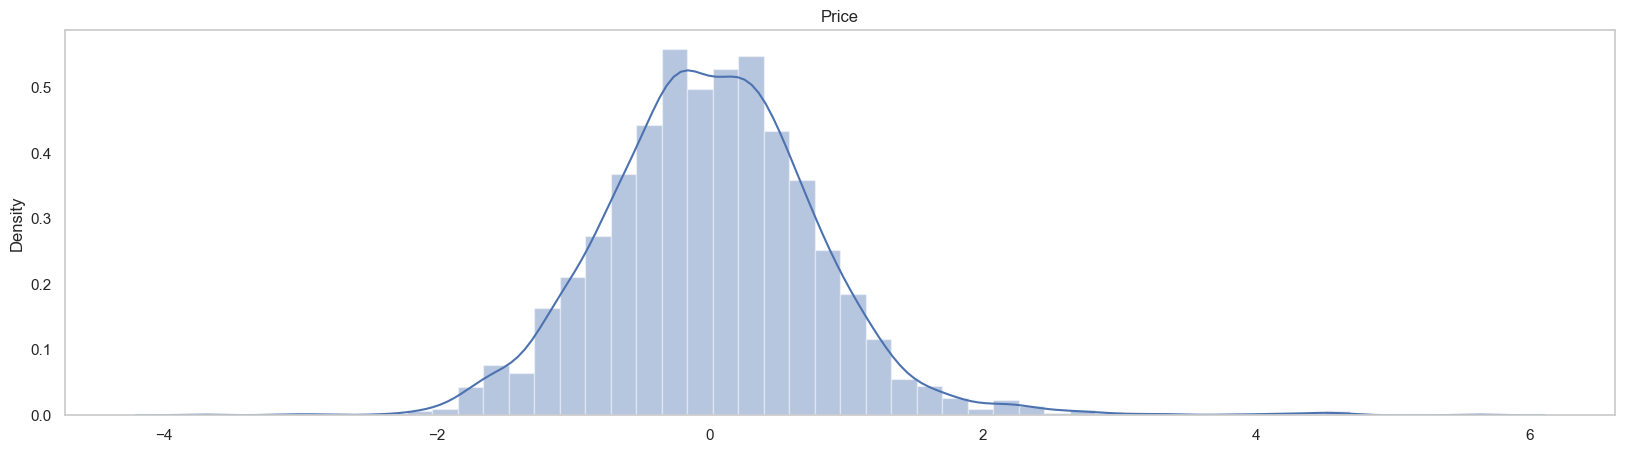

In [59]:
# Create function that print error metrics and plot the error 
def Error_Metrics(y_test, y_pred):
    
    """
    Create function that print error metrics and plot the error 
    
    """
    print('R2:', metrics.r2_score(y_test, y_pred))
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print('MSE:', metrics.mean_squared_error(y_test, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

    sns.set(style="whitegrid")
    plt.rcParams["axes.grid"] = False
    plot_objects = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    fig, ax1 = plot_objects
    sns.distplot(y_test - y_pred, ax=ax1)
    ax1.set_title("Price")
    ax1.set_xlabel(" ")

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_test_preds = lin_reg.predict(X_test)
y_train_preds = lin_reg.predict(X_train)

Error_Metrics(y_test, y_test_preds)

_**Notes**_

The residuals histogram looks normally distributed.


#####  Ridge Model

In [60]:
ridge_model = linear_model.Ridge(alpha = 0.01, normalize = True)
ridge_model.fit(X_train, y_train)             
y_predicts = ridge_model.predict(X_test) 
print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(metrics.mean_squared_error(y_test, y_predicts)),
        r2_score(y_test,y_predicts),
        mean_absolute_error(y_test,y_predicts)
        ))


        Mean Squared Error: 0.7950005618811498
        R2 Score: 0.33968565931701367
        Mean Absolute Error: 0.6038323184196053
     


##### Lasso model

In [61]:
Lasso_model = linear_model.Lasso(alpha = 0.001, normalize =False)
Lasso_model.fit(X_train, y_train)
y_predicts = Lasso_model.predict(X_test) 
print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(metrics.mean_squared_error(y_test, y_predicts)),
        r2_score(y_test,y_predicts) * 100,
        mean_absolute_error(y_test,y_predicts)
        ))


        Mean Squared Error: 0.7952801944682656
        R2 Score: 33.92210612029193
        Mean Absolute Error: 0.6038490227922422
     


##### Decision Tree Regression

In [62]:

Reg_tree=DecisionTreeRegressor(criterion='mse',max_depth=3,random_state=0)
Reg_tree=Reg_tree.fit(X_train,y_train)

y_predicts=Reg_tree.predict(X_test)
print("median absolute deviation (MAD): ",np.mean(abs(np.multiply(np.array(y_test.T-y_predicts),np.array(1/y_test)))))
print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(metrics.mean_squared_error(y_test, y_predicts)),
        r2_score(y_test,y_predicts) ,
        mean_absolute_error(y_test,y_predicts)
        ))

median absolute deviation (MAD):  3.24411156866433

        Mean Squared Error: 0.8126586503122758
        R2 Score: 0.3100268618019828
        Mean Absolute Error: 0.612348976739715
     


##### Random Forest regression

In [63]:
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1,verbose=1)
forest.fit(X_train, y_train.squeeze())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [64]:
#calculate scores for the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_train, y_train_preds)))

Random Forest MSE train: 0.076, test: 0.498
Random Forest R^2 train: 0.925, test: 0.925


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


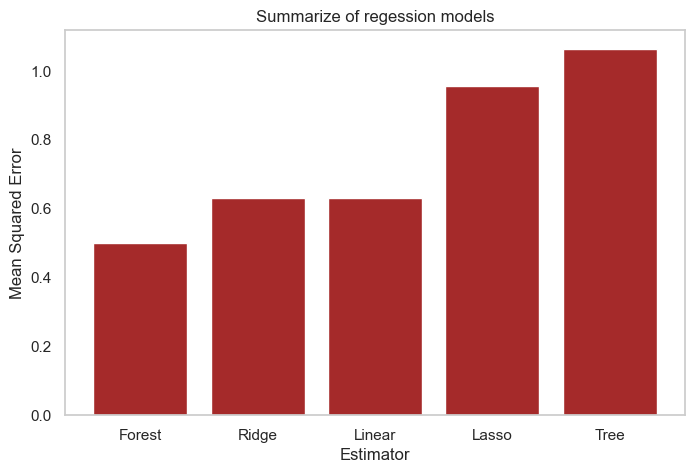

In [65]:
#summarize the error of the five models

rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), DecisionTreeRegressor(), RandomForestRegressor()]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'Tree', 'Forest'])
errvals = np.array([])


for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.mean_squared_error(y_test, e.predict(X_test))
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(8,5))
plt.bar(pos, errvals[srt], align='center', color='brown')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Mean Squared Error')
plt.title('Summarize of regession models')

sns.set(style="whitegrid")
plt.rcParams["axes.grid"] = False;

_**Notes**_

We can see that Random Forest model has the highest R^2 value(92%) and least Mean Squared Error. Hence it is the best model.

_**What are the main factors that influence Airbnb renting price?**_

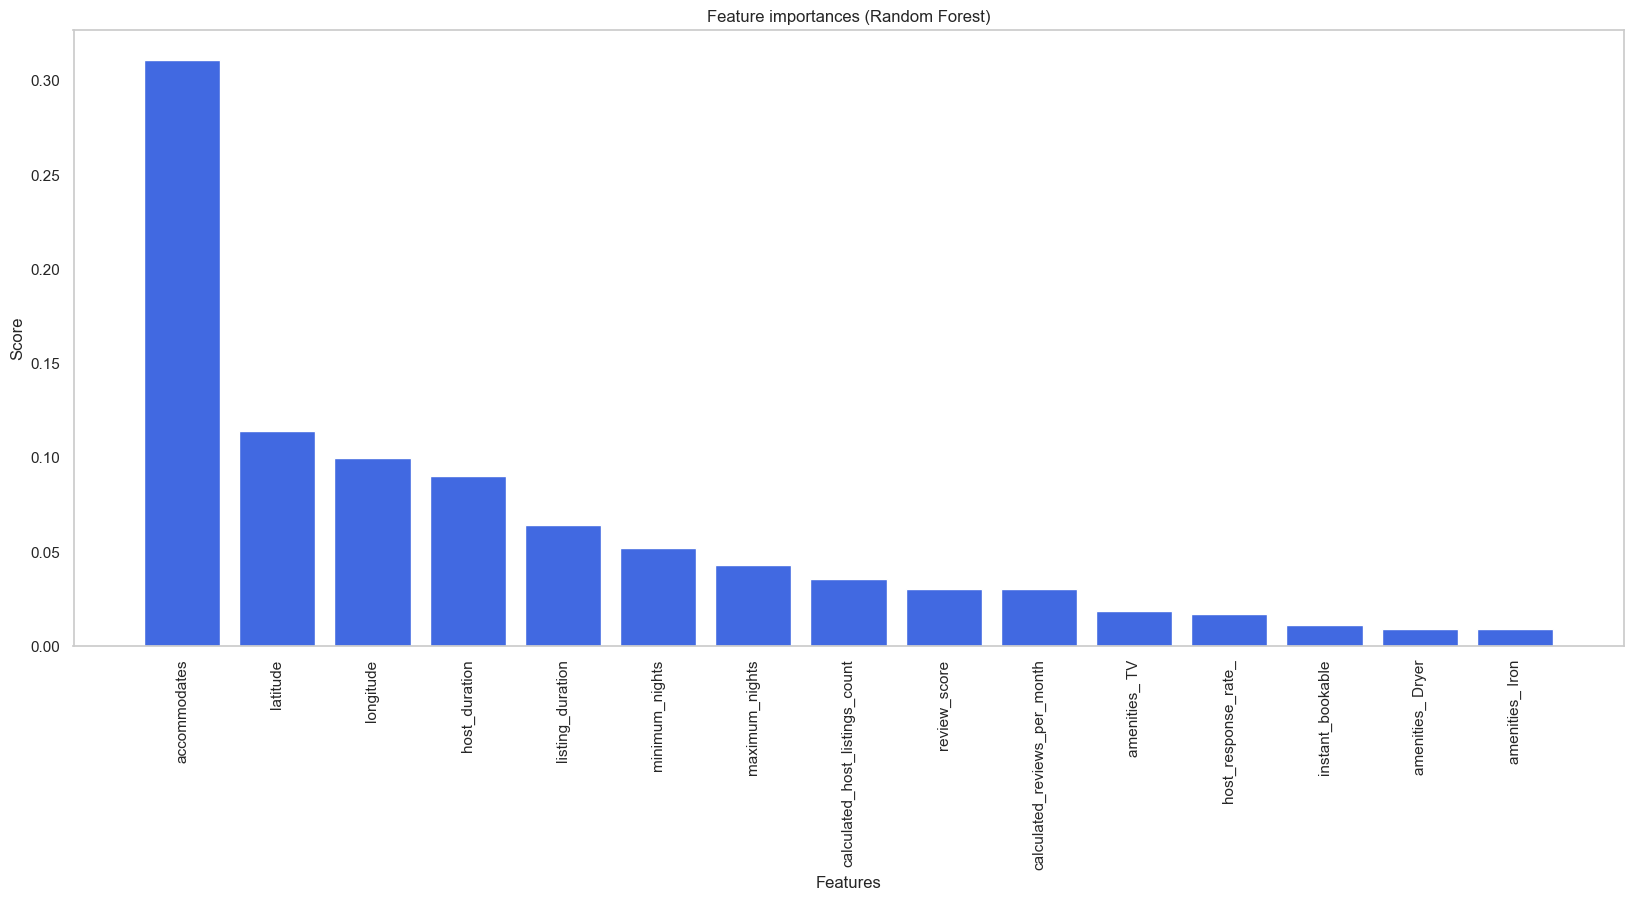

In [66]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#plot feature importances
plt.figure(figsize=(20,8))
plt.bar(y_pos, scores, align='center', color='Royalblue')
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')
sns.set(style="whitegrid")
plt.rcParams["axes.grid"] = False;
plt.show()

_**Notes**_

The most important feature is how many people the property accommodates, it's the first thing you would use to search for properties with in the first place. It is also not surprising that features related to location (latitude and longitude) and score/reviews are in the top ten. Both higher ratings and more numerous reviews can lead to a higher price.
The “Age/host duration” variable, namely, the duration of time since the listing was established, is the fourth most important feature affecting Airbnb listing prices. 


### The case of Toronto

In [67]:
# Create a new dataframe for regression
num_features = listings_t.dtypes[listings_t.dtypes != 'object'].index.tolist()
data_for_r_t = pd.DataFrame(listings_t[num_features])
# Log Transform the dependant variable
data_for_r_t["price_clean"] = np.log(data_for_r_t [["price_clean"]])

In [68]:
# Dropping from the X some colinear variables
X_r_t=data_for_r_t .drop(["price_clean",'host_since','bedrooms','beds','review_scores_location','number_of_reviews'], axis=1)
y_r_t = data_for_r_t [["price_clean"]]

# Scaling
scaler = StandardScaler()
X_r_t = pd.DataFrame(scaler.fit_transform(X_r_t), columns=list(X_r_t.columns))
y_r_t=scaler.fit_transform(y_r_t)

In [69]:
# Create train and test data sets
X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_r_t, y_r_t, test_size=0.2, random_state=42)
print('X_t_train.shape: ', X_t_train.shape, '\tX_t_test.shape: ', X_t_test.shape, '\nY_t_train.shape: ', y_t_train.shape, '\tY_t_test.shape: ', y_t_test.shape)

X_t_train.shape:  (14996, 24) 	X_t_test.shape:  (3750, 24) 
Y_t_train.shape:  (14996, 1) 	Y_t_test.shape:  (3750, 1)


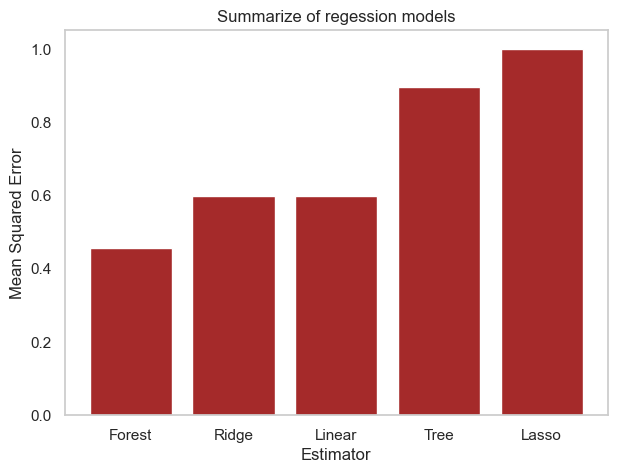

In [70]:
#summarize the five models

rs = 1
ests_t = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), DecisionTreeRegressor(), RandomForestRegressor()]
ests_t_labels = np.array(['Linear', 'Ridge', 'Lasso', 'Tree', 'Forest'])
errvals = np.array([])


for e in ests_t:
    e.fit(X_t_train, y_t_train)
    this_err = metrics.mean_squared_error(y_t_test, e.predict(X_t_test))
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center', color='brown')
plt.xticks(pos, ests_t_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Mean Squared Error')
plt.title('Summarize of regession models')

sns.set(style="whitegrid")
plt.rcParams["axes.grid"] = False;

_**Notes**_

We can see that Random Forest model has the least error. Hence it is the best model.

_**What are the main factors that influence Airbnb renting price?**_

In [71]:
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1,verbose=1)
forest.fit(X_t_train, y_t_train.squeeze())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [72]:
#calculate scores for the model
y_t_train_preds = forest.predict(X_t_train)
y_t_test_preds = forest.predict(X_t_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_t_train, y_t_train_preds),
        mean_squared_error(y_t_test, y_t_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_t_train, y_t_train_preds),
        r2_score(y_t_train, y_t_train_preds)))

Random Forest MSE train: 0.064, test: 0.454
Random Forest R^2 train: 0.936, test: 0.936


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


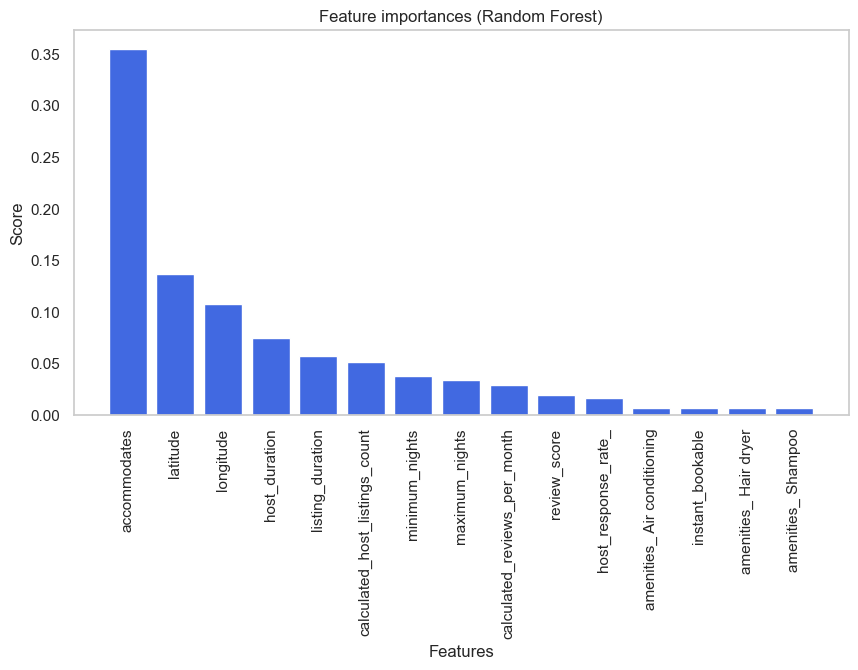

In [73]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_t_train.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', color='Royalblue')
plt.xticks(y_pos, features, rotation='vertical')
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')
sns.set(style="whitegrid")
plt.rcParams["axes.grid"] = False;
plt.show()

<a id='concl'></a>
## Conclusion

In this article, we took a look at AirBnB data from Montreal and Toronto to understand some areas of interest, especially pricing, following the Cross Industry Standard Process for Data Mining (CRISP-DM) process.

There were some useful insights found at each level, that helped us to identify some factors that can impact an Airbnb listing’s price, by using five regression models.

This work could be improved by implementing a recommendation system which suggests an airbnb listing using the keywords the user has provided. It would return the most relevant airbnb listing. 
